In [16]:
library(gridExtra)
library(matrixStats)
library(dplyr)
library(rlang)
library(reshape2)
library(clusterCrit)
library(grid)
library(ggrepel)
library(RColorBrewer)
library(dplyr)
library(IRdisplay)
library(scales)
library(survival)
library(corrplot)
library(Hmisc)
library(ggplot2)
library(survminer)
library(muhaz)
library(dplyr)
library(stringr)
options(warn=-1)
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
library(broom)
library(logistf)
library(ggfortify)
source("../../src/tools.R")
source("../script_figures/tools.R")
# source("../src/tools.R")


In [17]:
df_cardiff <- read.table("aml_prognosis.tsv")
df_nejm <- read.table("full_data_validation_NO_ITD.tsv")


In [18]:
colors_analysis <- c(gen="#BFBFBF",cyto="#2b8cbe")
val = c("#EE9937","#5C5C5C","#870C14","#BFBFBF","#59A08B","#2b8cbe","#a6bddb","#fdbb84","#e79f00","#000000","darkseagreen","lightskyblue","#0072B2","pink","blue","green")

df_w_correlates <- read.table("aml_prognosis.tsv")
df_final <- read.table("aml_prognosis.tsv")

cols_order <- c("t_15_17","inv_16","t_8_21","t_11","t_6_9","inv_3","additions","TP53_complex","NPM1","CEBPA_bi","DNMT3A_IDH1_2","WT1","chr_splicing_multiple","chr_splicing_1","not_assigned","no_events")

genes <- colnames(df_final[,c(5:88)])

cytos <- colnames(df_final[,c(89:158)])

eln <- colnames(df_final[,c(2,3,4)])
comp <- colnames(df_final[,c(170:186)])

all_gen <- c(5:88)
vect <- apply(X=df_final[,all_gen],2,FUN=function(x) 100*length(which(x==1))/dim(df_final)[1])
gen <- colnames(df_final[,match(names(vect[vect>=2]),names(df_final))])

all_cyto <- c(89:158)
vect <- apply(X=df_final[,all_cyto],2,FUN=function(x) 100*length(which(x==1))/dim(df_final)[1])
cyto <- colnames(df_final[,match(names(vect[vect>=2]),names(df_final))])

clin <- colnames(df_final[,c(159:165)])
demo <- colnames(df_final[,c(166:167)])
pal <- c(eln="#EE9937",comp="#59A08B",gen="#BFBFBF",cyto="#2b8cbe",clin="#870C14",demo="#a6bddb",age="#a6bddb",gen_cyto="pink",eln_gen_cyto="#fdbb84",comp_gen_cyto="lightgoldenrod",all="lightsalmon")  
colors <- c("black","gray1","grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7",
"#9ad0f3", "#D55E00", 
"lightgoldenrod","lightskyblue","#F0E442",
"firebrick3","#000000","#870C14","#a6bddb","mistyrose4","#fdbb84","gray","deeppink","darkblue","darkred","darkgreen","purple","forestgreen","gray2")
              
### Color Components ###
cols_component <- colnames(df_final %>% dplyr:: select(starts_with("full_component_")))

color_values <- c("grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7","#9ad0f3", "#D55E00", "lightgoldenrod","lightskyblue","#F0E442",
                  "firebrick3","#000000","#870C14","#a6bddb","mistyrose4","#fdbb84","gray","deeppink","darkblue","darkred","darkgreen",
                  "purple","forestgreen")
tmp <- NULL
for (co in cols_component){
    tmp1 <- df_w_correlates[df_w_correlates[,co]==1,]
    tmp1$comparison <- str_remove(co,"full_component_")
    tmp <- rbind(tmp,tmp1)
    }
tmp$fill_pal <- factor(tmp$comparison)
names(color_values) <- levels(factor(tmp$fill_pal))
color_values["overlap"] <- "purple"

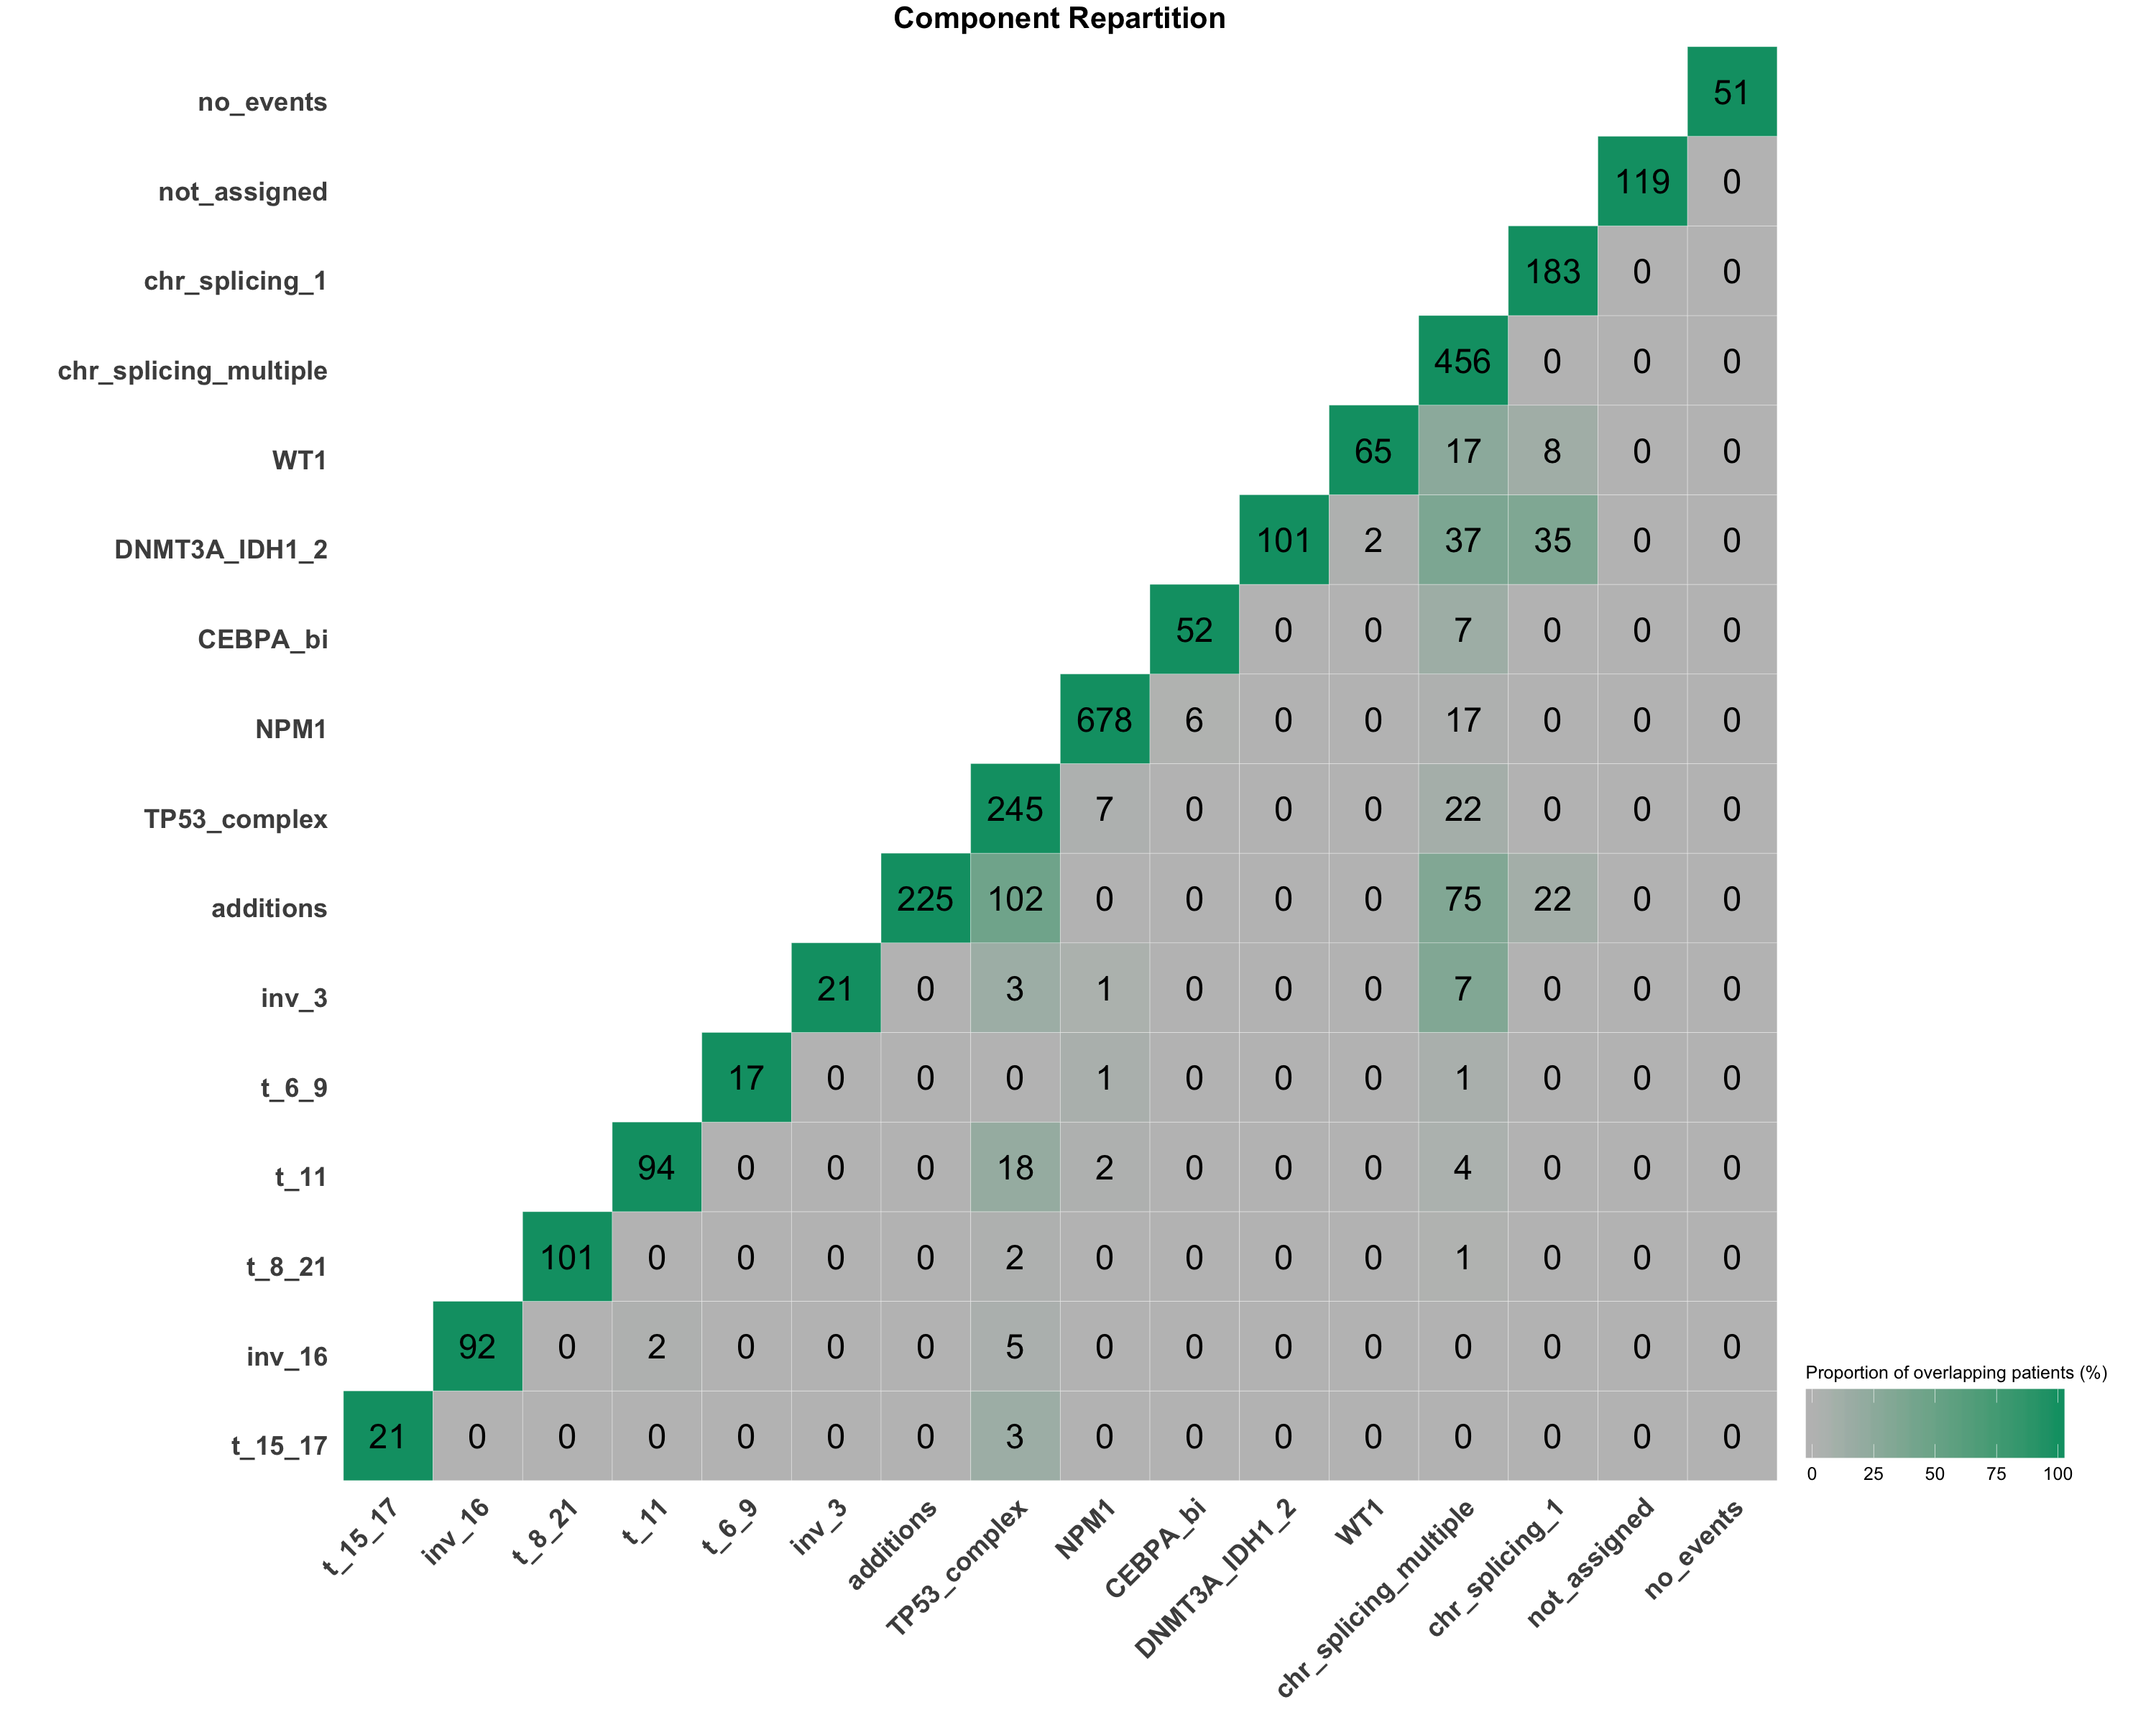

In [19]:
set_notebook_plot_size(25,20)
# png("tmp.png",width=5000,height=5000,res=300)
comp_repartition(df_final,cols_component,cols_order=cols_order)
# dev.off()

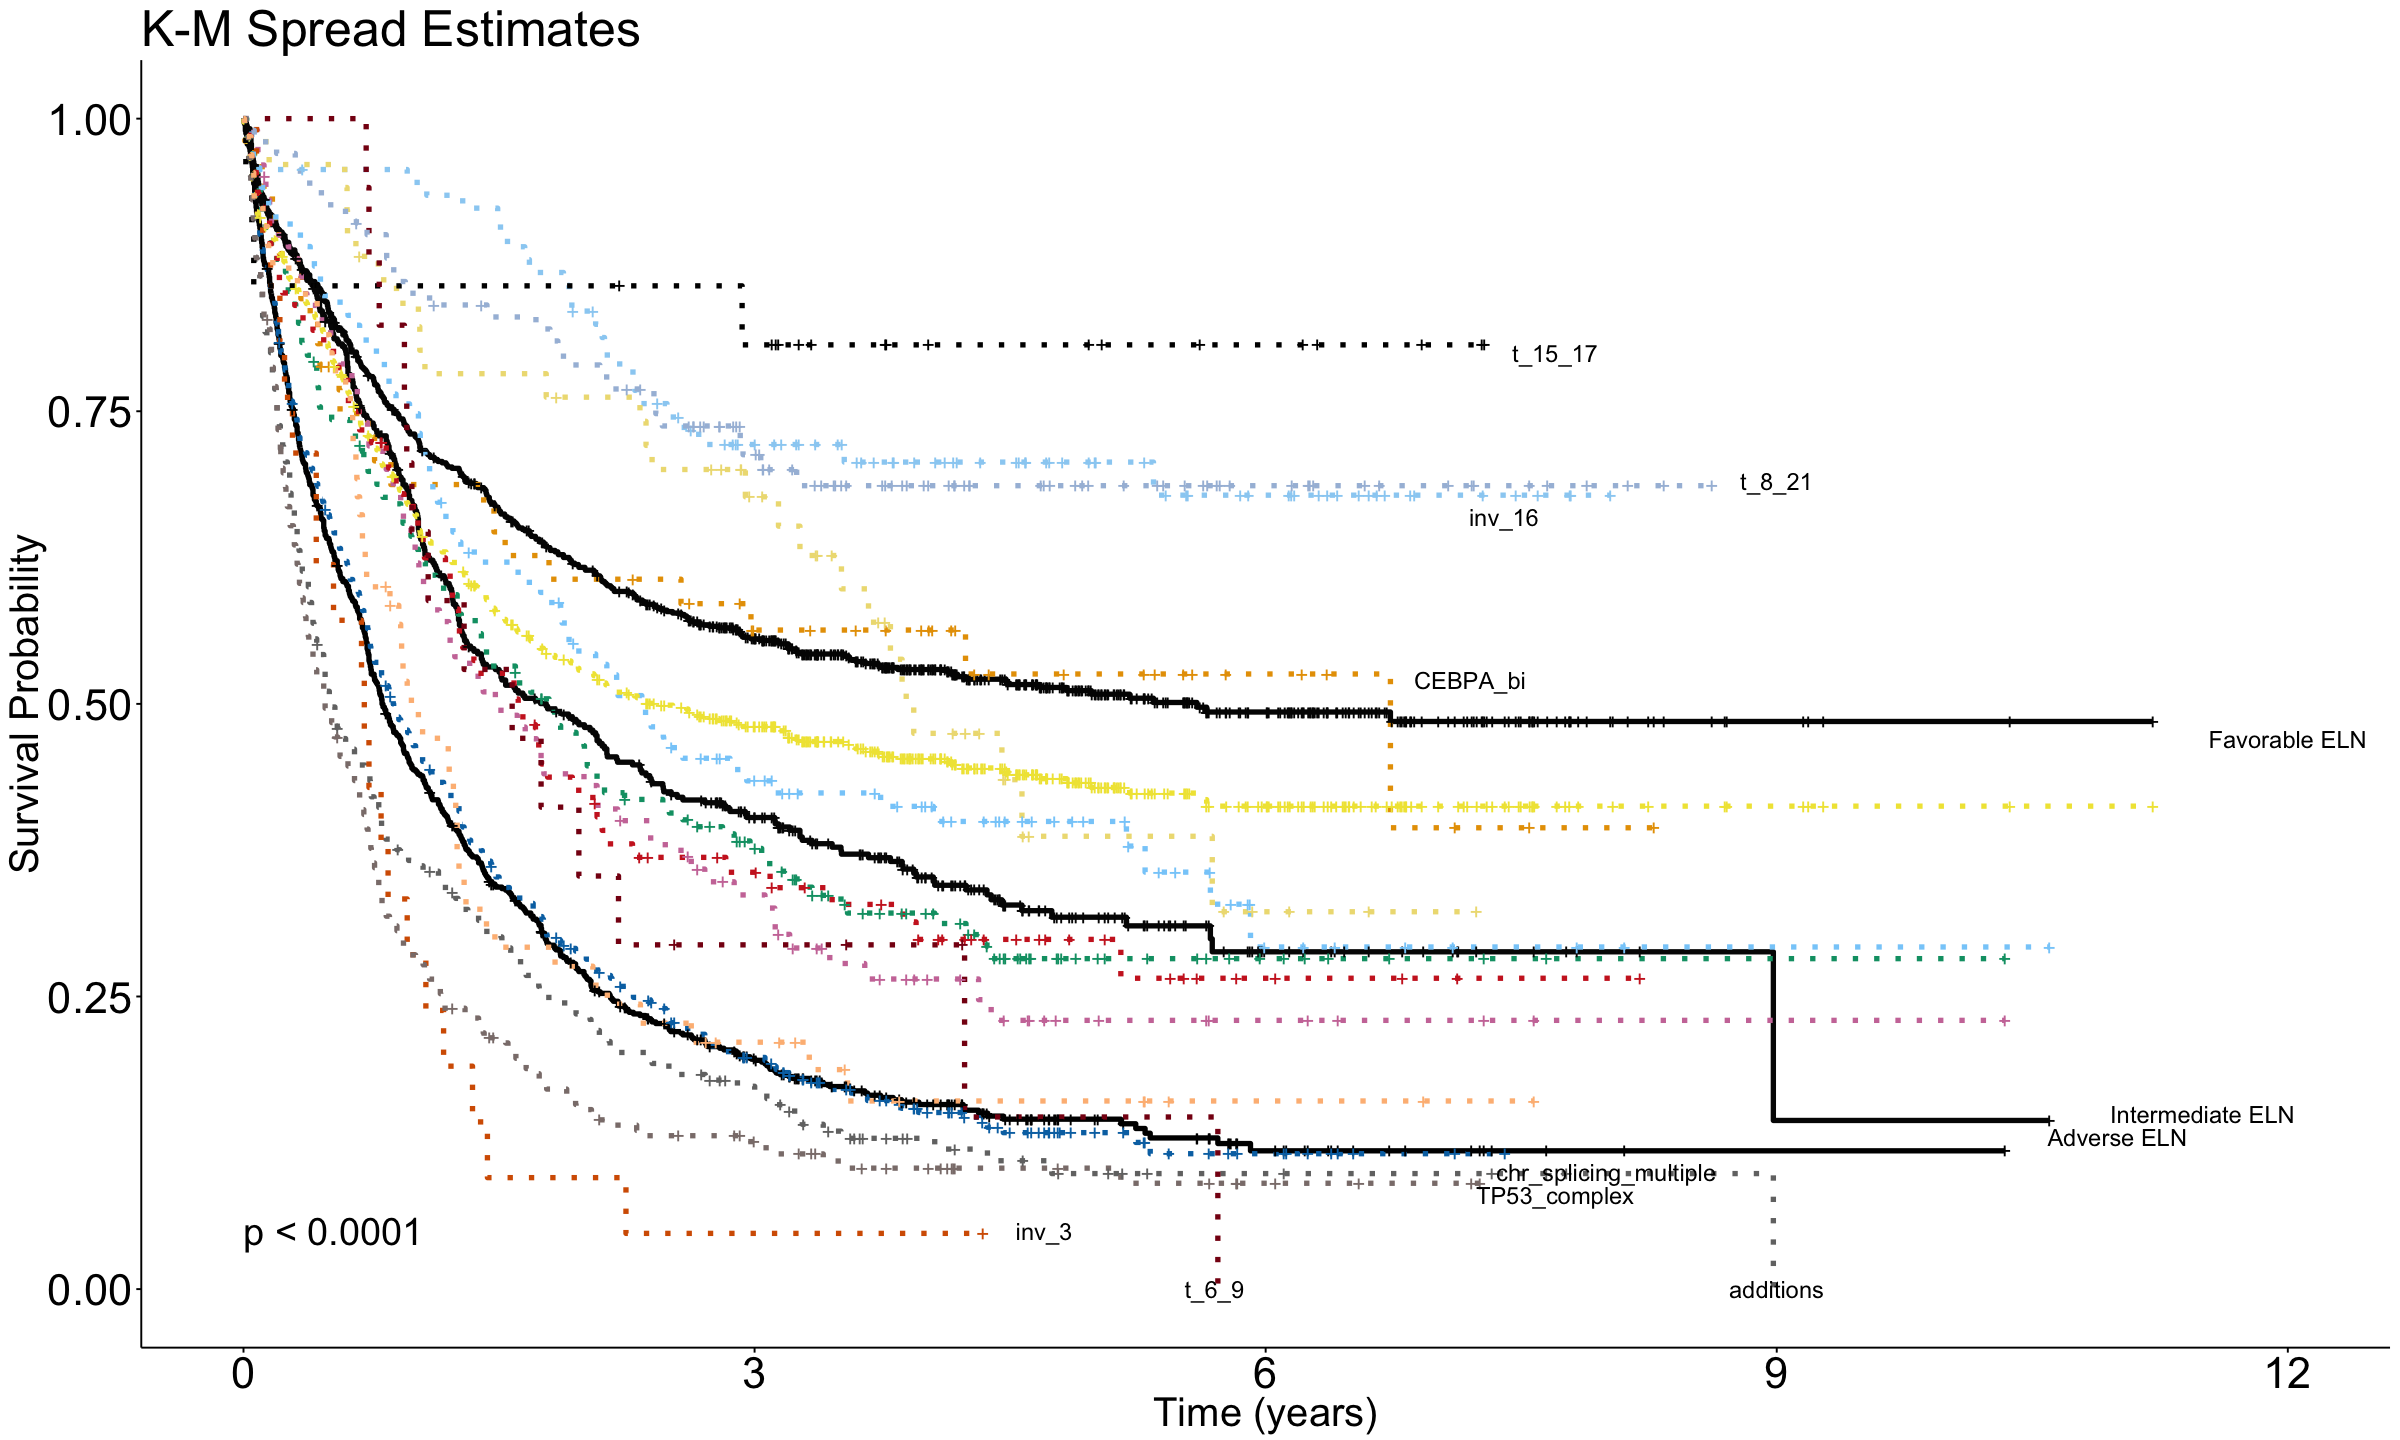

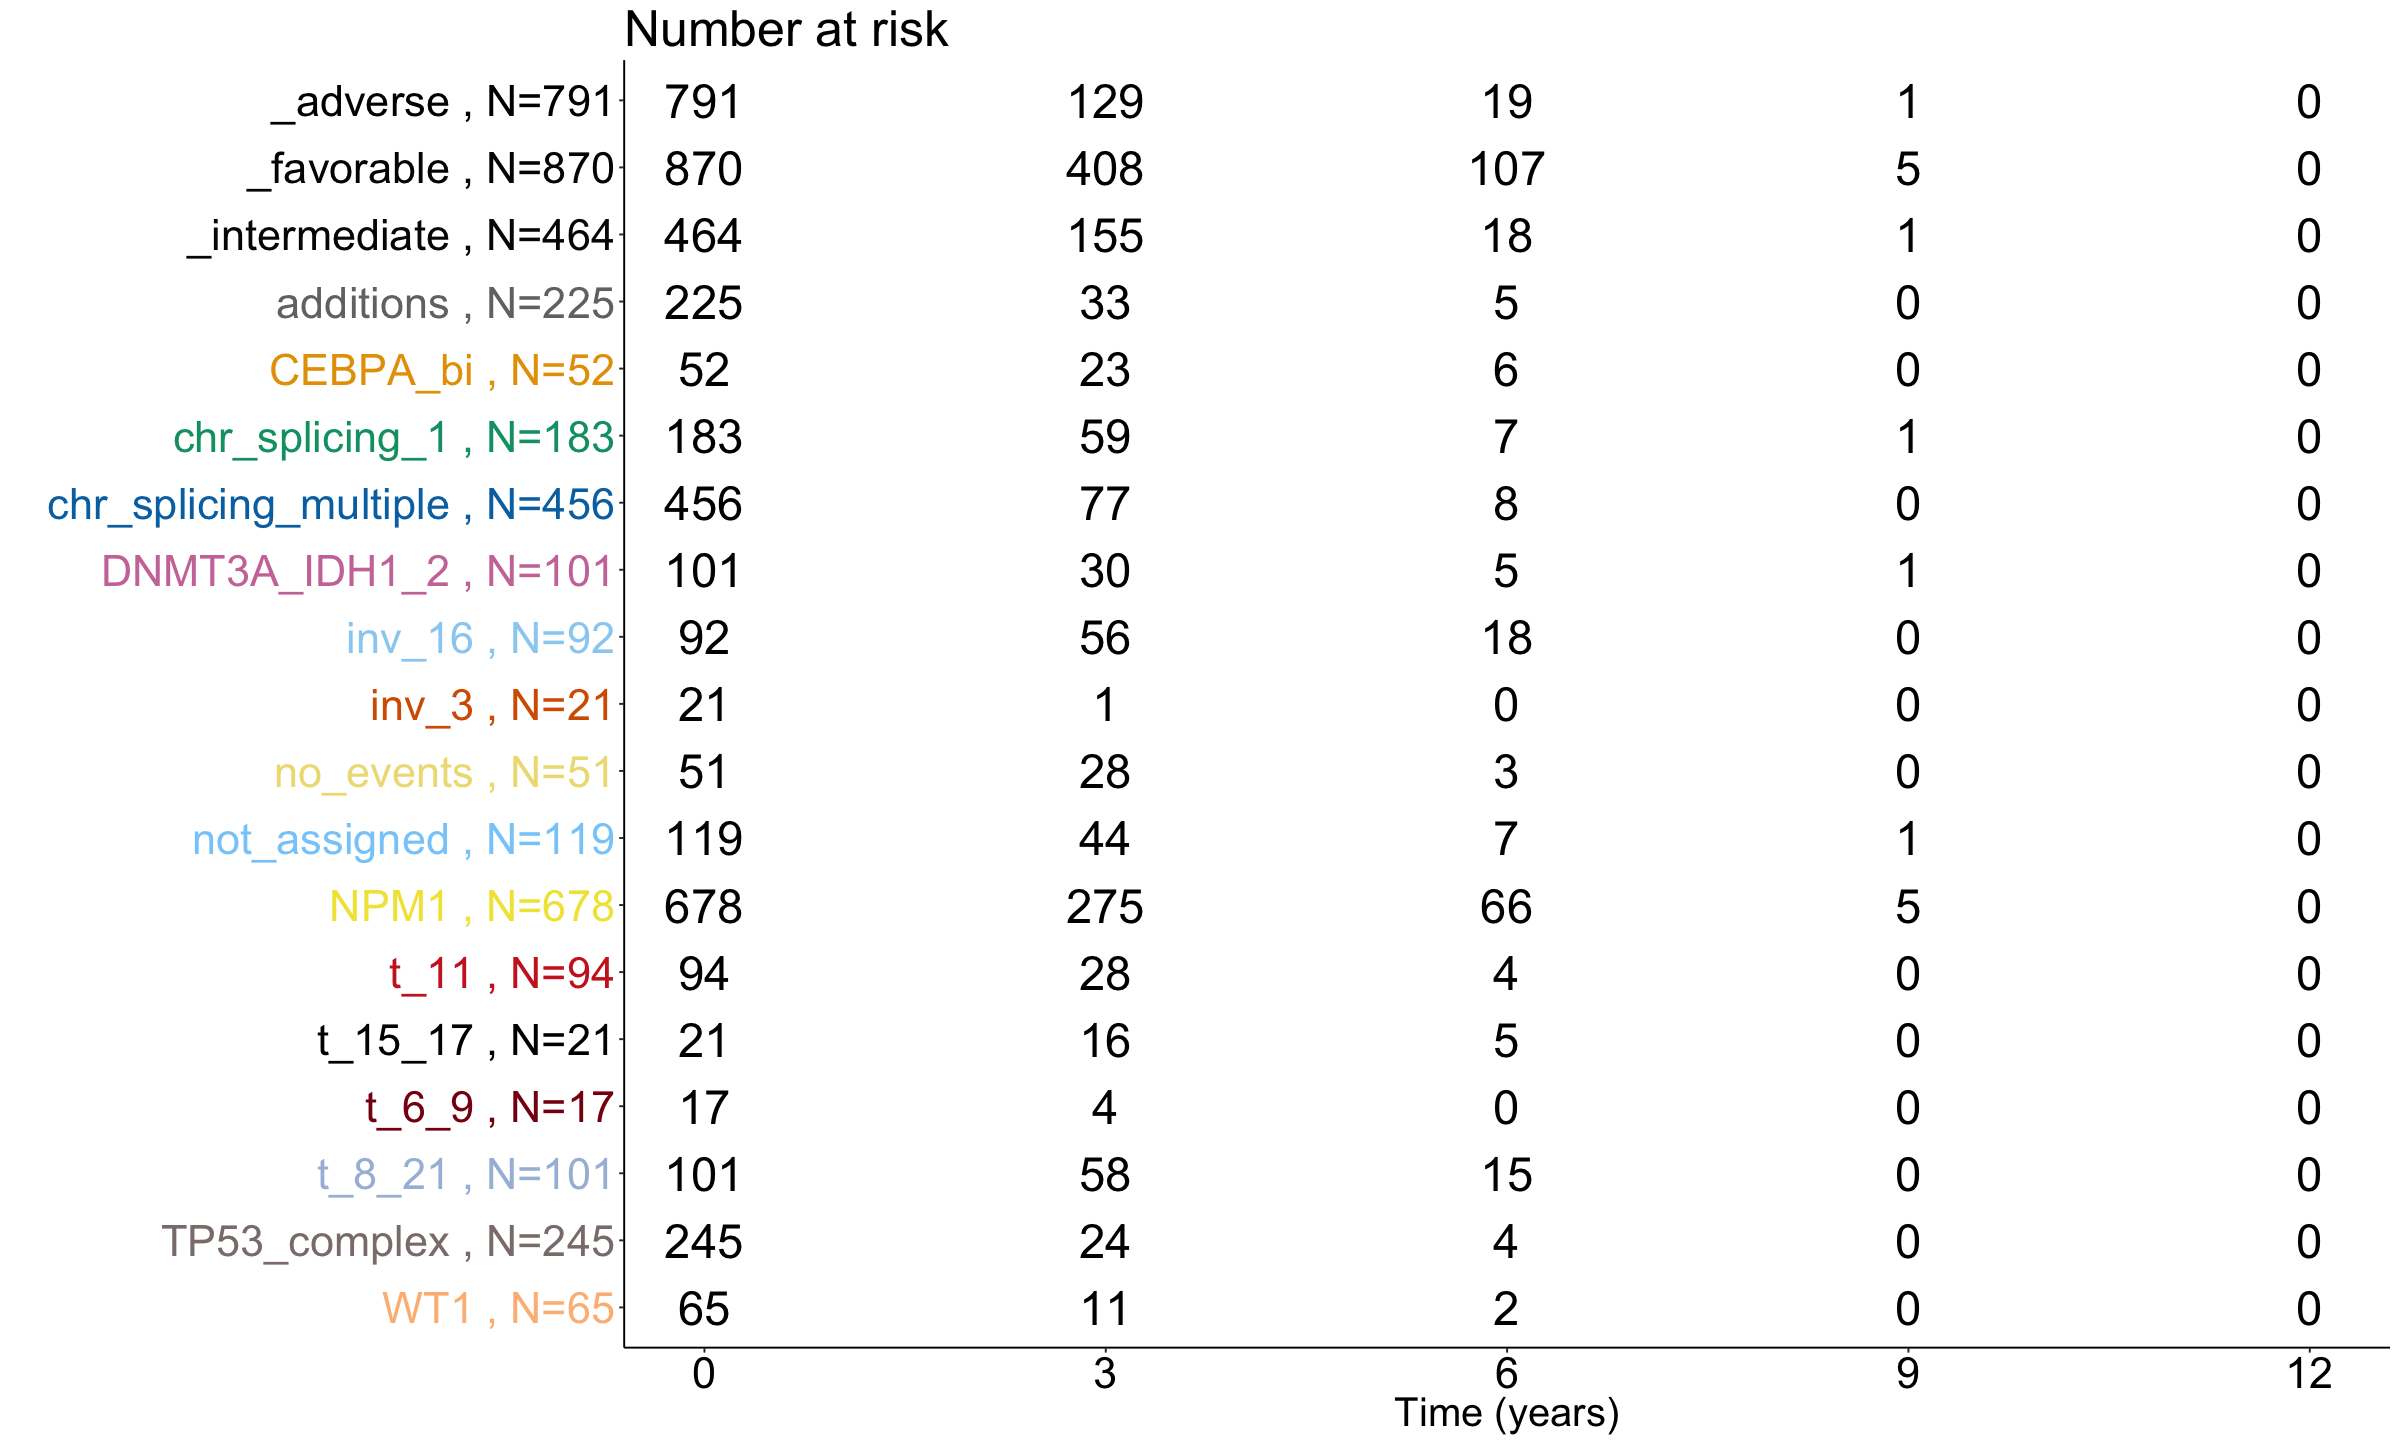

In [20]:
colors <- c("black","gray1","gray2",as.vector(unlist(color_values)))

tmp <- NULL
for (col in cols_component){
    tmp1 <- df_w_correlates[df_w_correlates[,col]==1,]
    tmp1$comparison <- str_remove(col,"full_component_")
    tmp <- rbind(tmp,tmp1)
    }

tmp1 <- df_final

tmp1$comparison <- ifelse(tmp1$eln_2017==1,"_adverse",
                          ifelse(tmp1$eln_2017==2,"_intermediate","_favorable"))
                          
tmp <- rbind(tmp,tmp1)
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,submain = "K-M Spread Estimates",vals=colors,linetype=c(1,1,1,rep(3,16)),size=1.5,y="Survival Probability",legend="none",risk.tab=T)


set_notebook_plot_size(20,12)
# png("figures/spread_surv_plot.png",width=5500,height=4500,res=350)
p$plot + ggplot2::annotate("text", 
                                x = c(4.7,5.7,7.7,9,8,11,11.5,12,7.2,7.4,9,7.7), y = c(0.05,0,0.08,0,0.1,0.13,0.15,0.47,0.52,0.66,0.69,0.8),
                                label = c("inv_3","t_6_9","TP53_complex","additions","chr_splicing_multiple","Adverse ELN","Intermediate ELN",
                                          "Favorable ELN","CEBPA_bi","inv_16","t_8_21","t_15_17"), size = 5)

p$table

In [8]:
lis <- c("PD15299a","PD15474c","PD20298a","PD23097c","PD25174a")

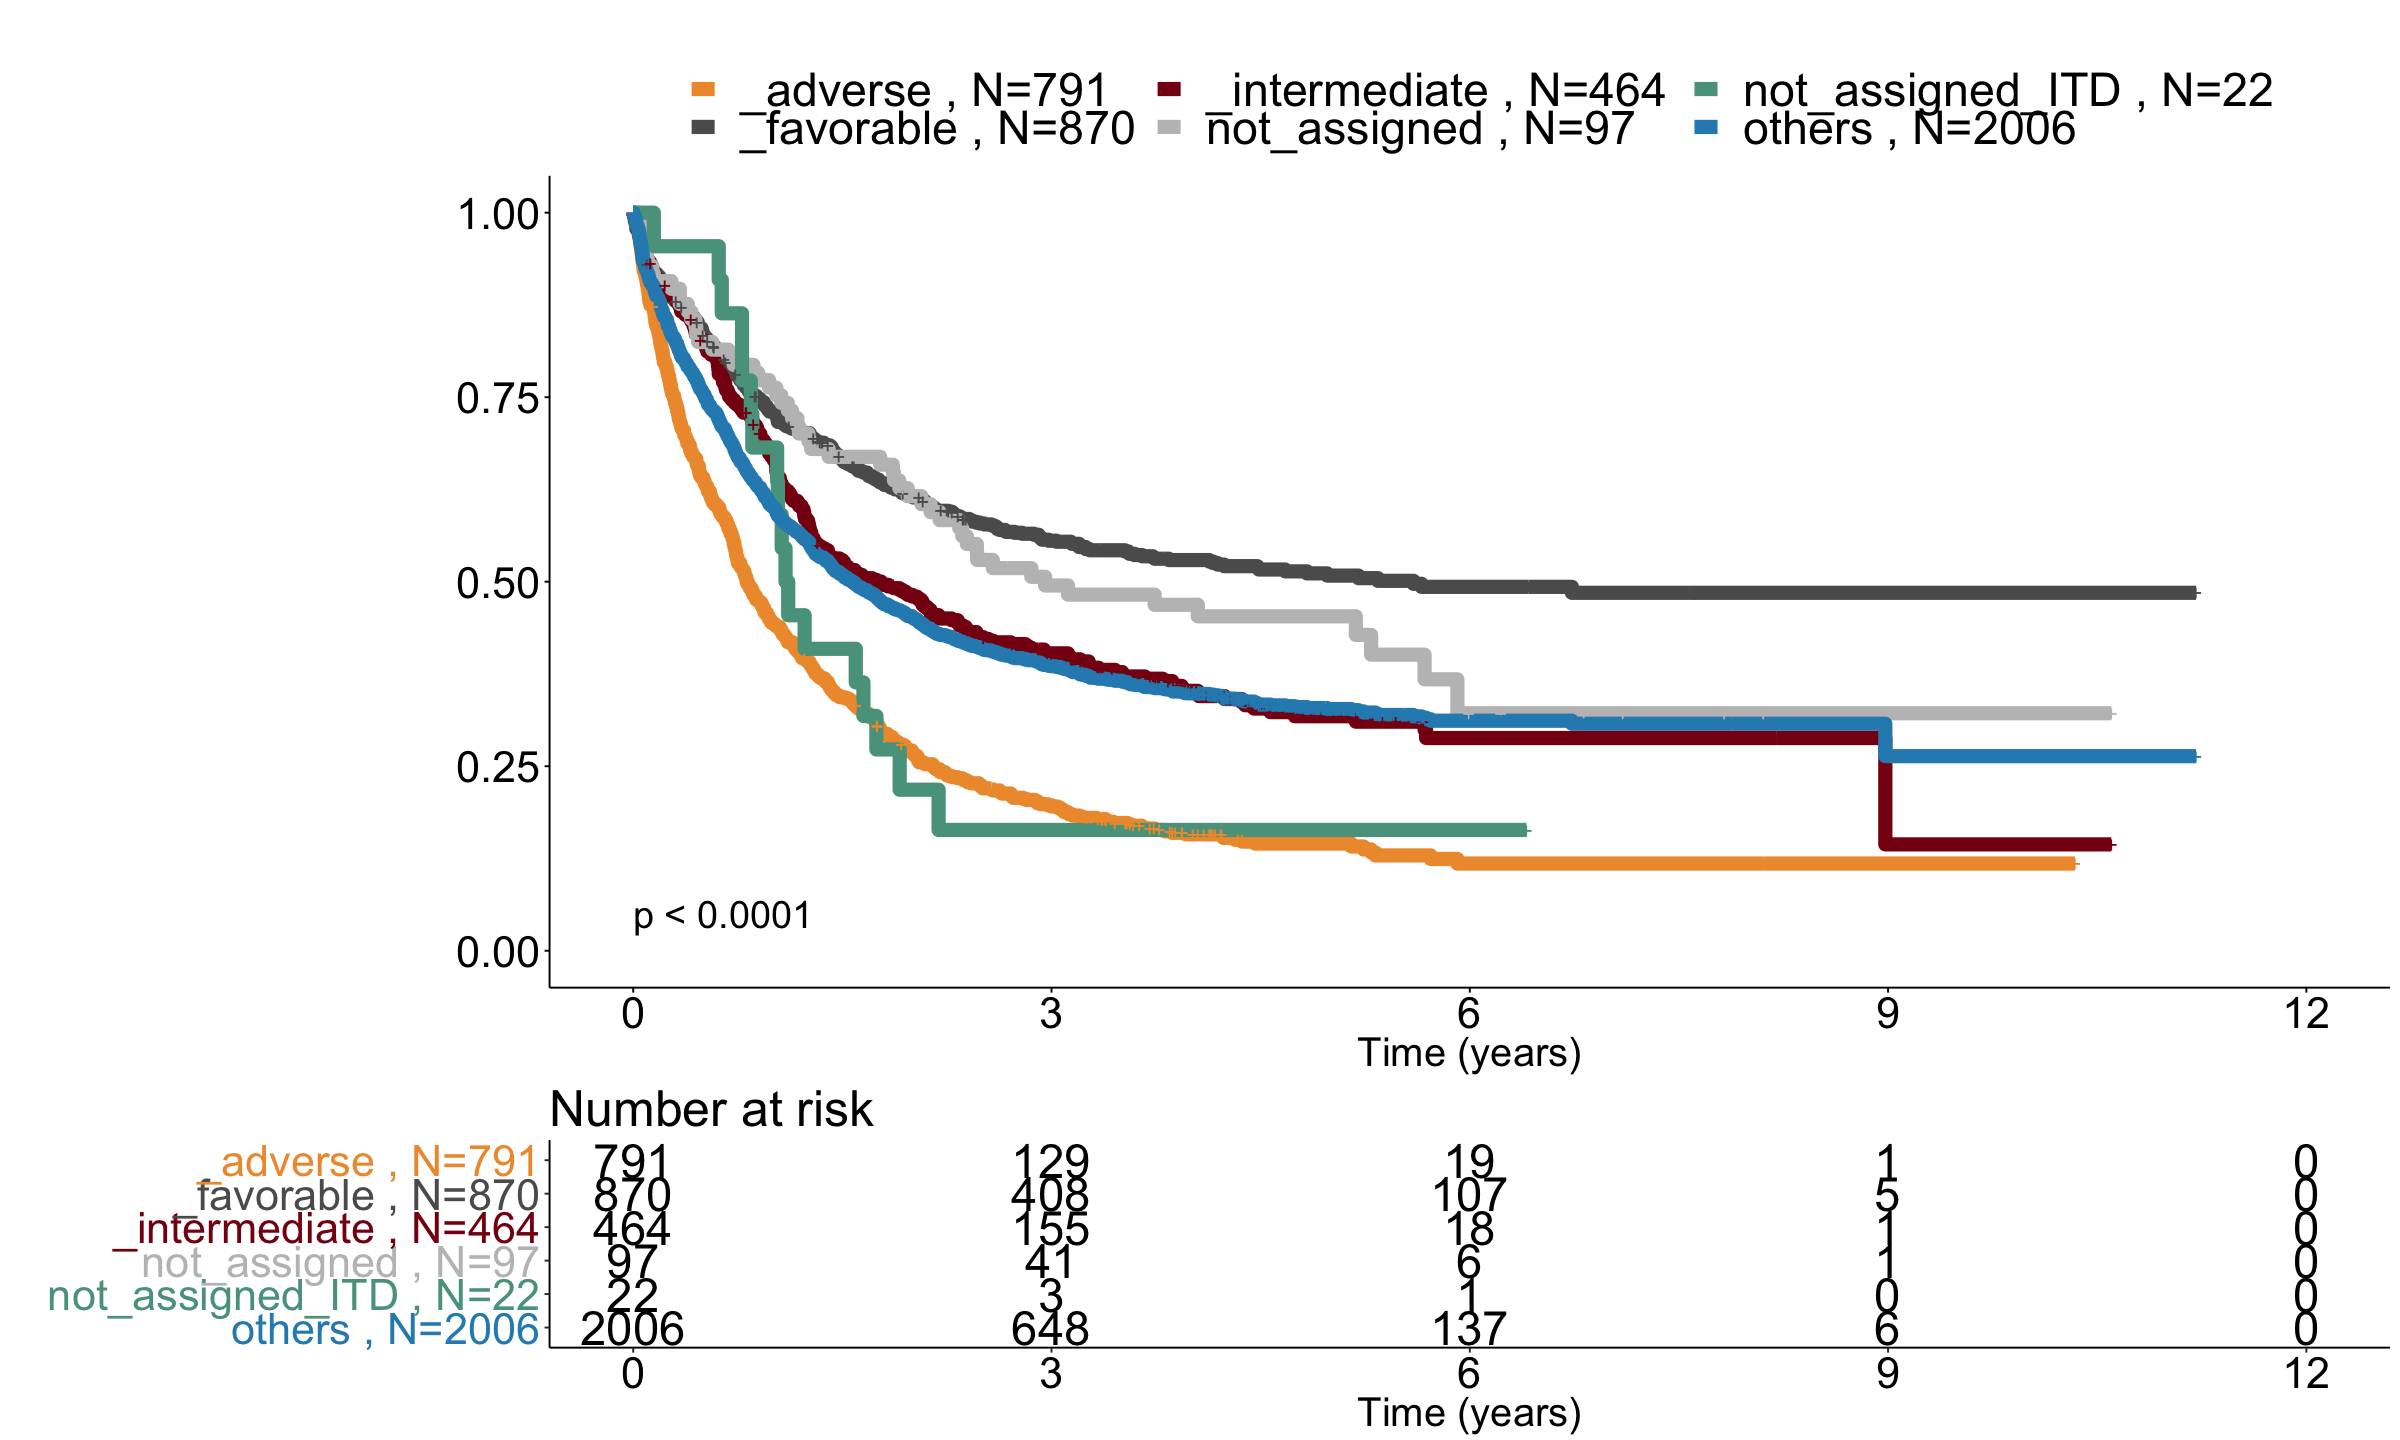

In [9]:
tmp <- df_final
tmp$comparison <- ifelse(tmp$full_component_not_assigned==1 & tmp$ITD==1,"not_assigned_ITD",
                     ifelse(tmp$full_component_not_assigned==1,"not_assigned","others"))



tmp1 <- df_final

tmp1$comparison <- ifelse(tmp1$eln_2017==1,"_adverse",
                          ifelse(tmp1$eln_2017==2,"_intermediate","_favorable"))
                          
tmp <- rbind(tmp,tmp1)
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
plot_surv_curves(fit,risk.tab = T)


# NEW MOLECULAR CLASSIFICATION

In [10]:
df_final$molecular_classification <- "none"

df_final[(df_final$NPM1==1 |df_final$inv_16==1 | df_final$t_8_21==1 | df_final$t_15_17==1 | (df_final$full_component_additions==1 & df_final$overlap==0)) & df_final$molecular_classification=="none","molecular_classification"] <- "favorable"

df_final[(df_final$full_component_chr_splicing_1==1 | df_final$full_component_not_assigned==1) & df_final$molecular_classification=="none" ,"molecular_classification"] <- "intermediate"
          
df_final[(df_final$full_component_additions==1 | df_final$full_component_TP53_complex==1 | df_final$full_component_chr_splicing_multiple==1  | df_final$inv_3==1) & df_final$molecular_classification=="none","molecular_classification"] <- "adverse"      
          
df_final[(df_final$CEBPA_bi==1 | df_final$full_component_no_events==1) & df_final$molecular_classification=="none","molecular_classification"] <- "favorable"
          
df_final[(df_final$full_component_t_11==1 | df_final$t_6_9==1 | df_final$WT1==1 | df_final$full_component_DNMT3A_IDH1_2==1 ) & df_final$molecular_classification=="none" ,"molecular_classification"] <- "intermediate"

# df_final[(df_final$full_component_additions==1 | df_final$full_component_TP53_complex==1 | df_final$full_component_chr_splicing_multiple==1  | df_final$inv_3==1) & df_final$molecular_classification=="none","molecular_classification"] <- "adverse"      

#order is important! adverse . then intermediate otherwise we . overlap
df_final[df_final$molecular_classification=="intermediate" & df_final$ITD==1,"molecular_classification"] <- "adverse"

df_final[df_final$molecular_classification=="favorable" & df_final$ITD==1,"molecular_classification"] <- "intermediate"



In [11]:
df_nejm$molecular_classification <- "none"

df_nejm[(df_nejm$NPM1==1 | df_nejm$inv_16==1 | df_nejm$t_8_21==1 | df_nejm$t_15_17==1 | (df_nejm$full_component_additions==1 & df_nejm$overlap==0)) & df_nejm$molecular_classification=="none","molecular_classification"] <- "favorable"

df_nejm[(df_nejm$full_component_chr_splicing_1==1| df_nejm$full_component_not_assigned==1) & df_nejm$molecular_classification=="none" ,"molecular_classification"] <- "intermediate"
          
df_nejm[(df_nejm$full_component_additions==1 | df_nejm$full_component_TP53_complex==1 | df_nejm$full_component_chr_splicing_multiple==1  | df_nejm$inv_3==1) & df_nejm$molecular_classification=="none","molecular_classification"] <- "adverse"      
          
df_nejm[(df_nejm$CEBPA_bi==1 | df_nejm$full_component_no_events==1) & df_nejm$molecular_classification=="none","molecular_classification"] <- "favorable"
          
df_nejm[(df_nejm$full_component_t_11==1 | df_nejm$t_6_9==1 | df_nejm$WT1==1 | df_nejm$full_component_DNMT3A_IDH1_2==1 ) & df_nejm$molecular_classification=="none" ,"molecular_classification"] <- "intermediate"


#order is important! adverse . then intermediate otherwise we . overlap
df_nejm[df_nejm$molecular_classification=="intermediate" & df_nejm$ITD==1,"molecular_classification"] <- "adverse"

df_nejm[df_nejm$molecular_classification=="favorable" & df_nejm$ITD==1,"molecular_classification"] <- "intermediate"

In [12]:
tmp <- df_final
tmp$comparison <- paste("NEW_",tmp$molecular_classification,sep="")


tmp1 <- df_final

tmp1$comparison <- ifelse(tmp1$eln_2017==1,"ELN_adverse",
                          ifelse(tmp1$eln_2017==2,"ELN_intermediate","ELN_favorable"))
                          
tmp <- rbind(tmp,tmp1)
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,risk.tab = T,linetype=c(3,3,3,1,1,1),font.legend = 18,y="Survival Probability",submain = "Cardiff Data")

tmp <- df_nejm
tmp$comparison <- paste("NEW_",tmp$molecular_classification,sep="")


tmp1 <- df_nejm

tmp1$comparison <- ifelse(tmp1$eln_2017_adverse==1,"ELN_adverse",
                          ifelse(tmp1$eln_2017_intermediate==1,"ELN_intermediate","ELN_favorable"))
                          
tmp <- rbind(tmp,tmp1)
surv_object <- Surv(time = tmp$OS, event = tmp$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp)
q <- plot_surv_curves(fit,risk.tab = T,xlim=c(0,12),break.time.by=3,linetype=c(3,3,3,1,1,1),font.legend = 18,submain = "Nejm Data")

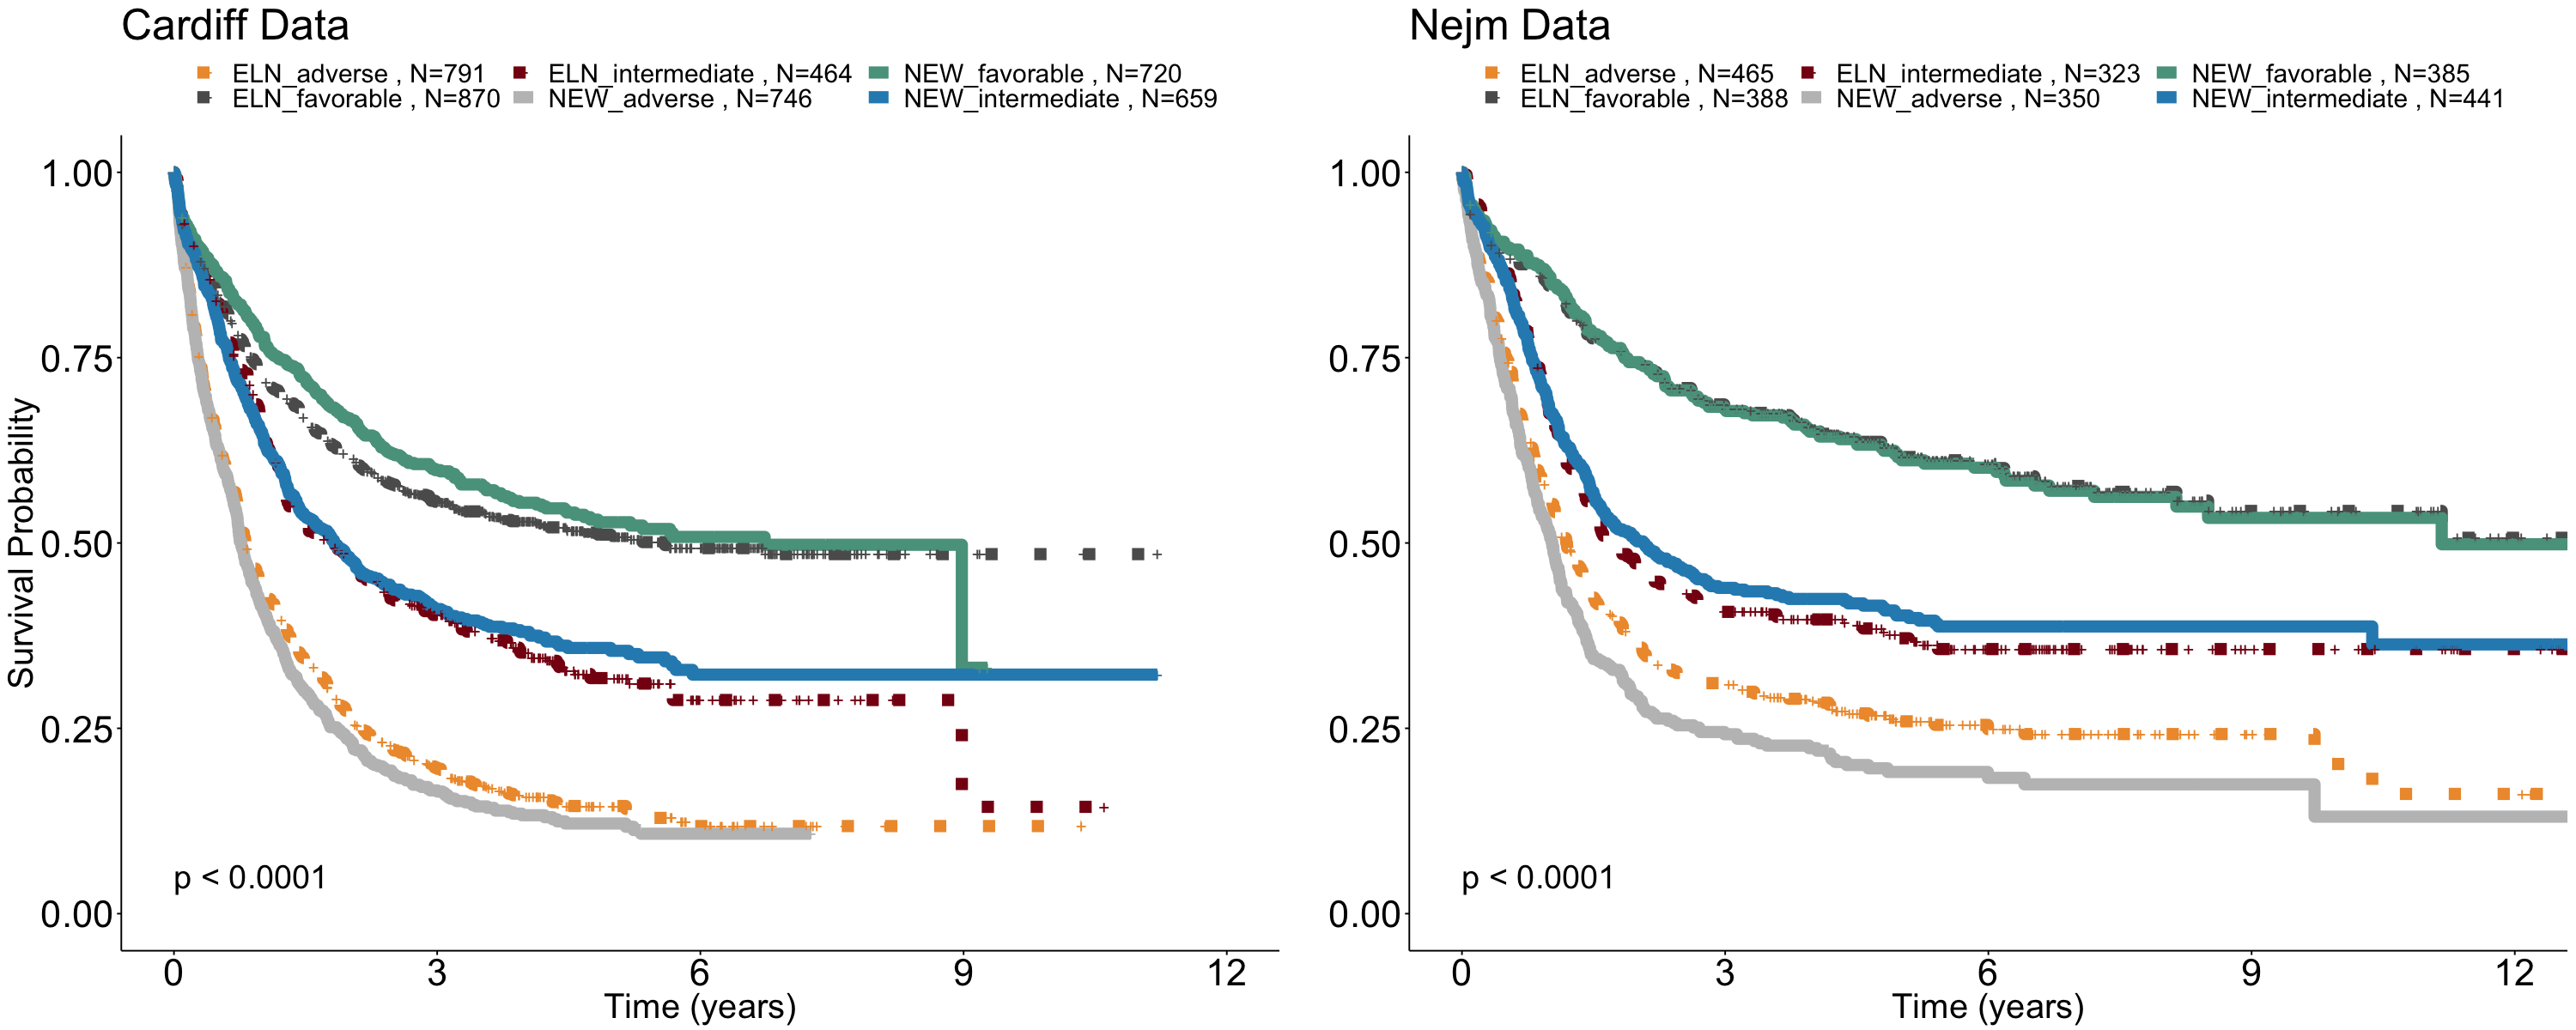

In [13]:
set_notebook_plot_size(25,10)
grid.arrange(p$plot,q$plot,nrow=1)

# Intersection Validation

# Favorable

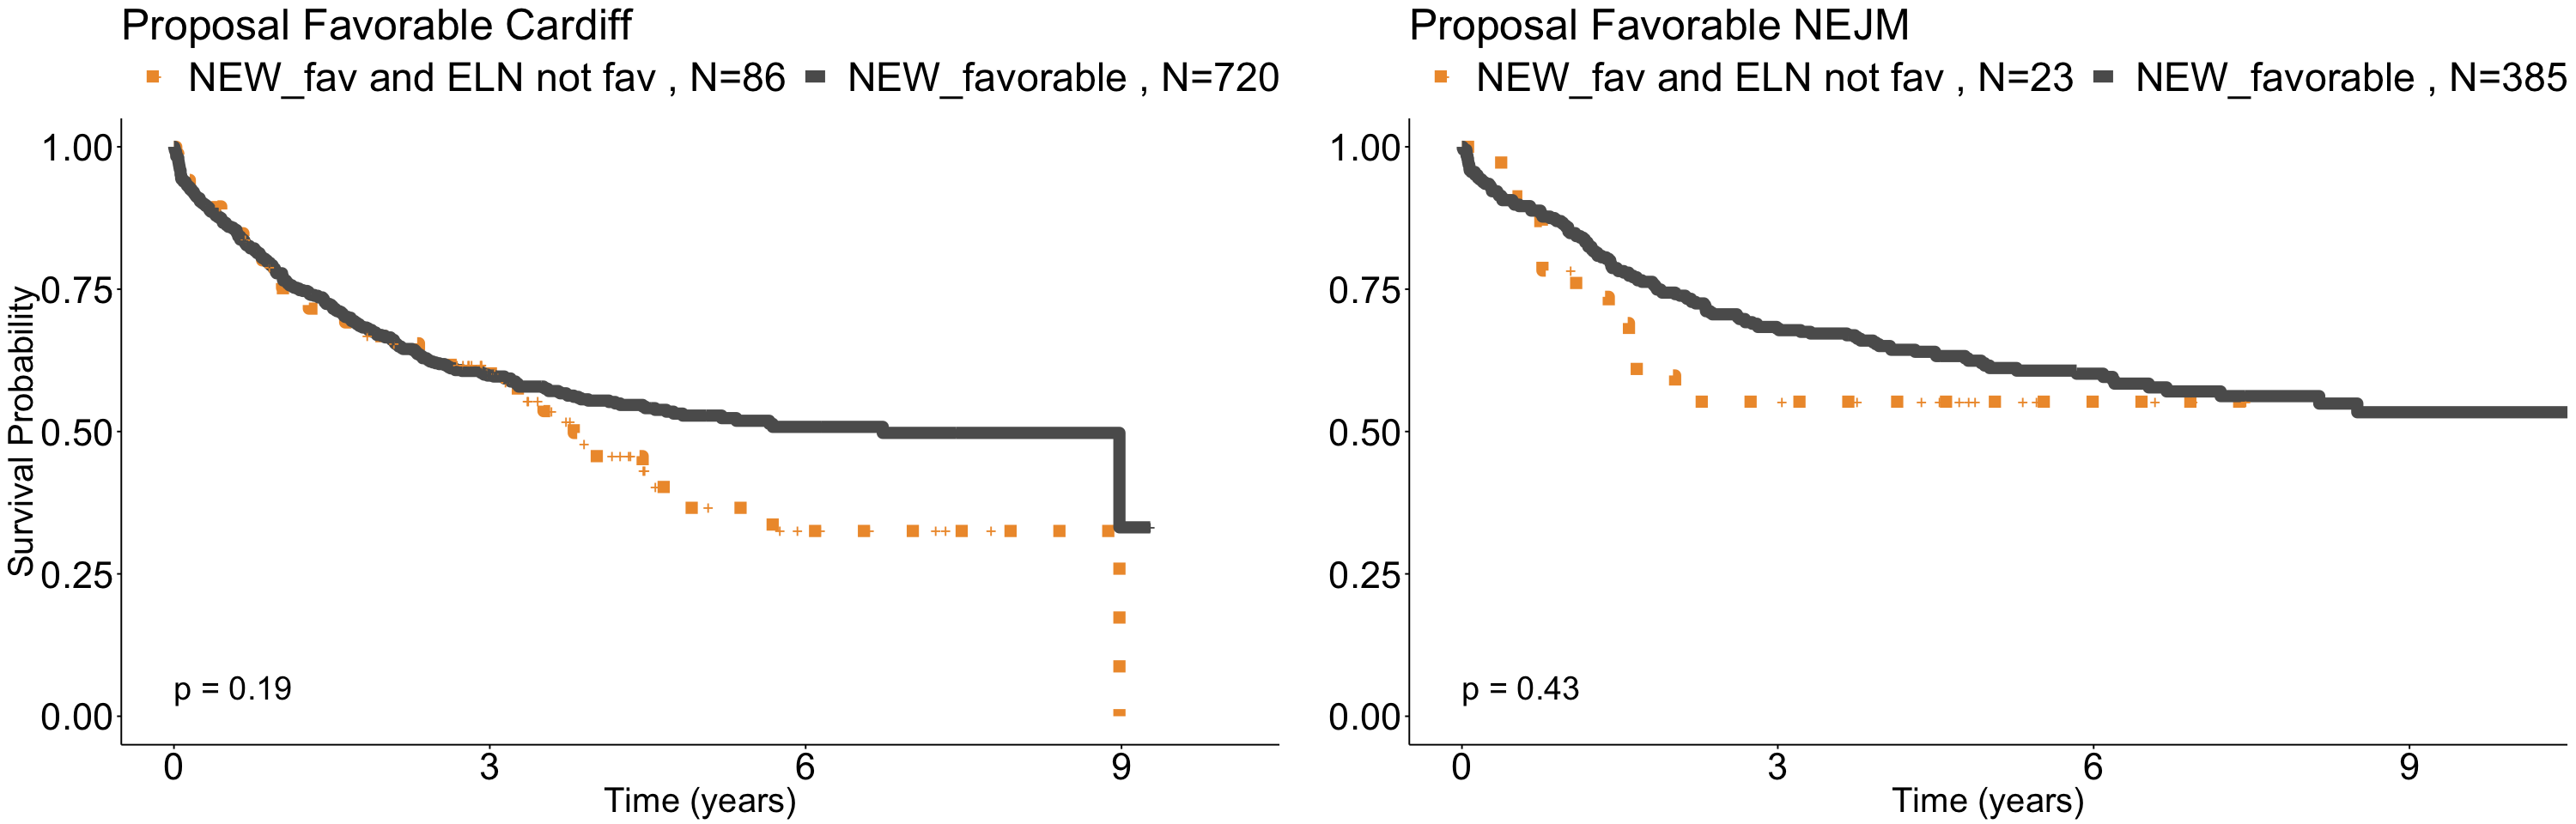

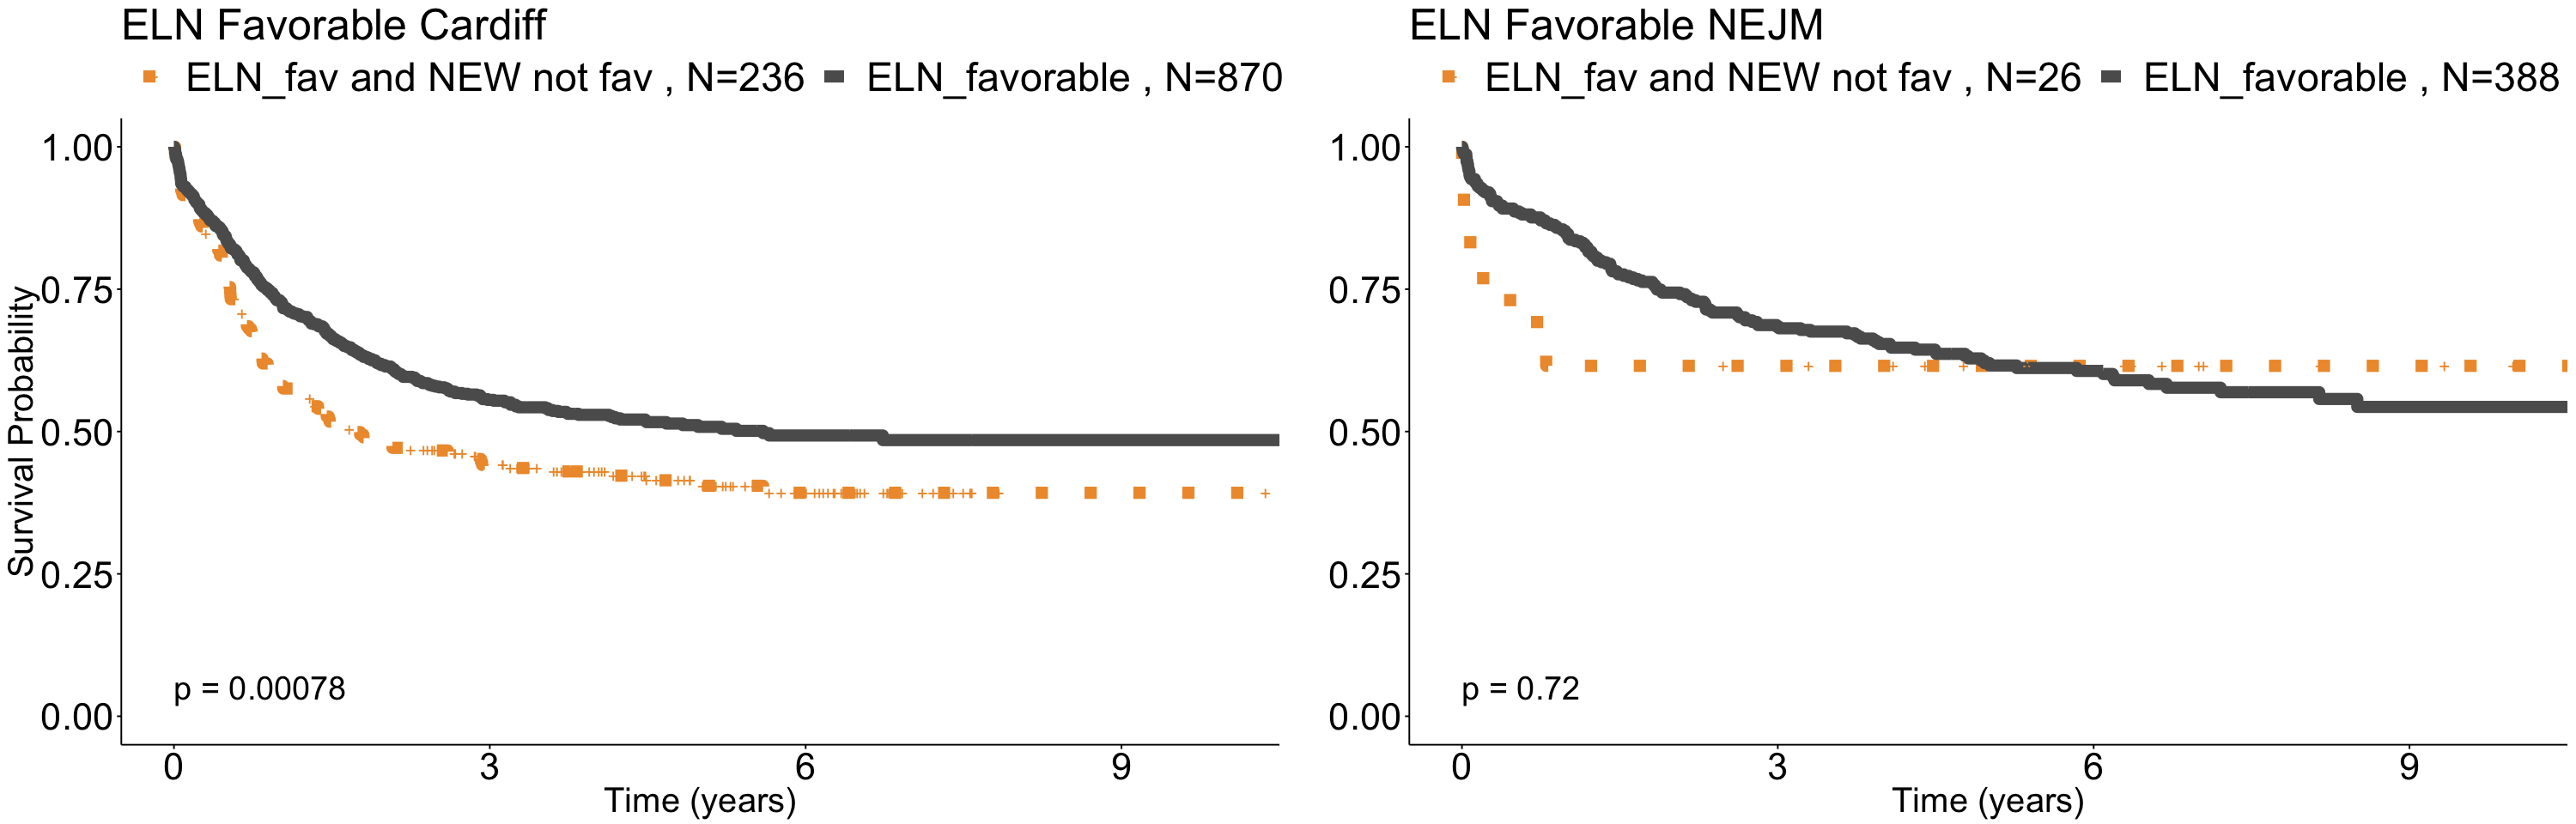

In [75]:
# NEW Intersect

tmp <- df_final[df_final$eln_2017_favorable!=1 & df_final$molecular_classification=="favorable",]
tmp$comparison <- "NEW_fav and ELN not fav"

tmp1 <- df_final[df_final$molecular_classification=="favorable",]

tmp1$comparison <- paste("NEW",tmp1$molecular_classification,sep="_")
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,linetype=c(3,1),submain="Proposal Favorable Cardiff",xlim=c(0,10),break.time.by=3,y="Survival Probability")

tmp <- df_nejm[df_nejm$eln_2017_favorable!=1 & df_nejm$molecular_classification=="favorable",]
tmp$comparison <- "NEW_fav and ELN not fav"

tmp1 <- df_nejm[df_nejm$molecular_classification=="favorable",]

tmp1$comparison <- paste("NEW",tmp1$molecular_classification,sep="_")
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$OS, event = tmp$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp)
q <- plot_surv_curves(fit,linetype=c(3,1,3,1),submain="Proposal Favorable NEJM",xlim=c(0,10),break.time.by=3)

grid.arrange(p$plot,q$plot,nrow=1)

#ELN Intersect

tmp <- df_final[df_final$eln_2017_favorable==1 & df_final$molecular_classification!="favorable",]
tmp$comparison <- "ELN_fav and NEW not fav"

tmp1 <- df_final[df_final$eln_2017_favorable==1,]

tmp1$comparison <- ifelse(tmp1$eln_2017_adverse==1,"ELN_adverse",
                          ifelse(tmp1$eln_2017_intermediate==1,"ELN_intermediate","ELN_favorable"))
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,linetype=c(3,1,3,1),submain="ELN Favorable Cardiff",xlim=c(0,10),break.time.by=3,y="Survival Probability")

tmp <- df_nejm[df_nejm$eln_2017_favorable==1 & df_nejm$molecular_classification!="favorable",]
tmp$comparison <- "ELN_fav and NEW not fav"

tmp1 <- df_nejm[df_nejm$eln_2017_favorable==1,]

tmp1$comparison <- ifelse(tmp1$eln_2017_adverse==1,"ELN_adverse",
                          ifelse(tmp1$eln_2017_intermediate==1,"ELN_intermediate","ELN_favorable"))
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$OS, event = tmp$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp)
q <- plot_surv_curves(fit,linetype=c(3,1,3,1),submain="ELN Favorable NEJM",xlim=c(0,10),break.time.by=3)

grid.arrange(p$plot,q$plot,nrow=1)



# Intermediate

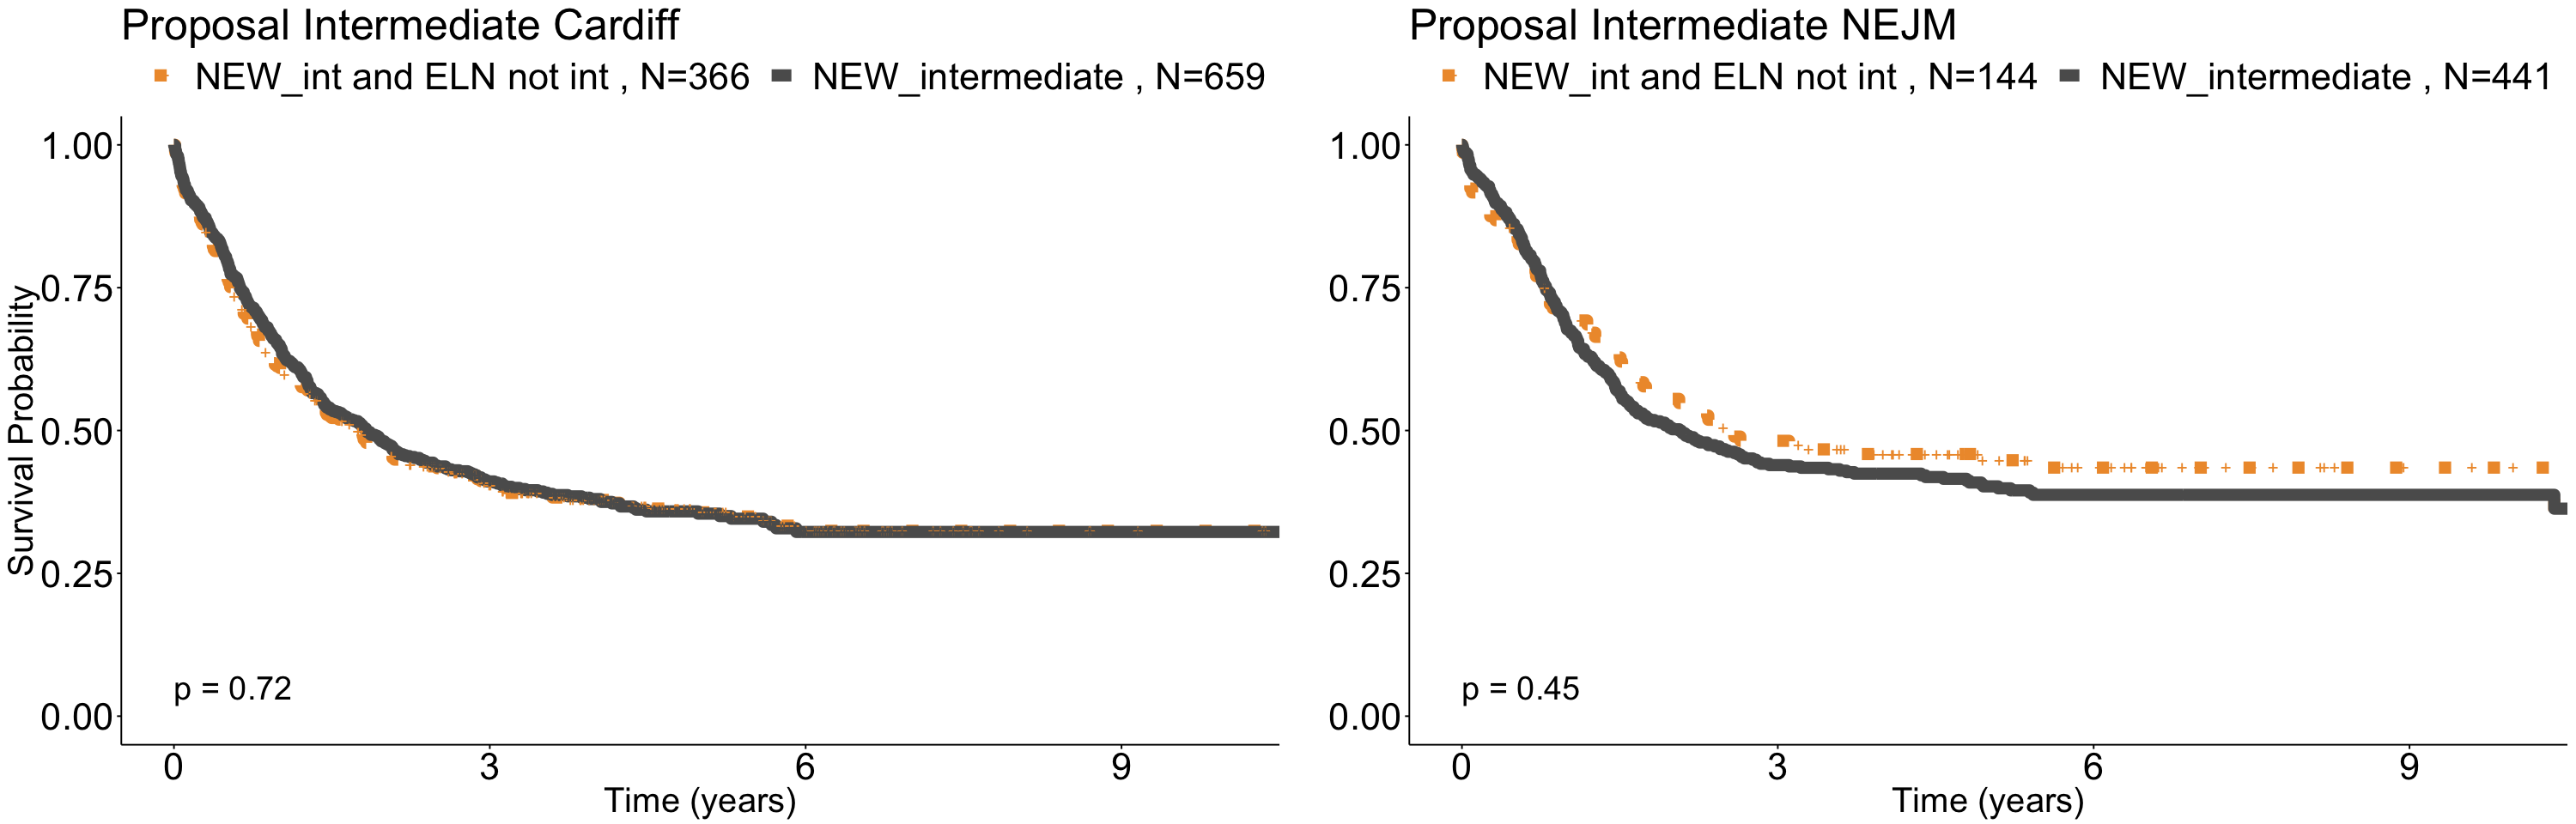

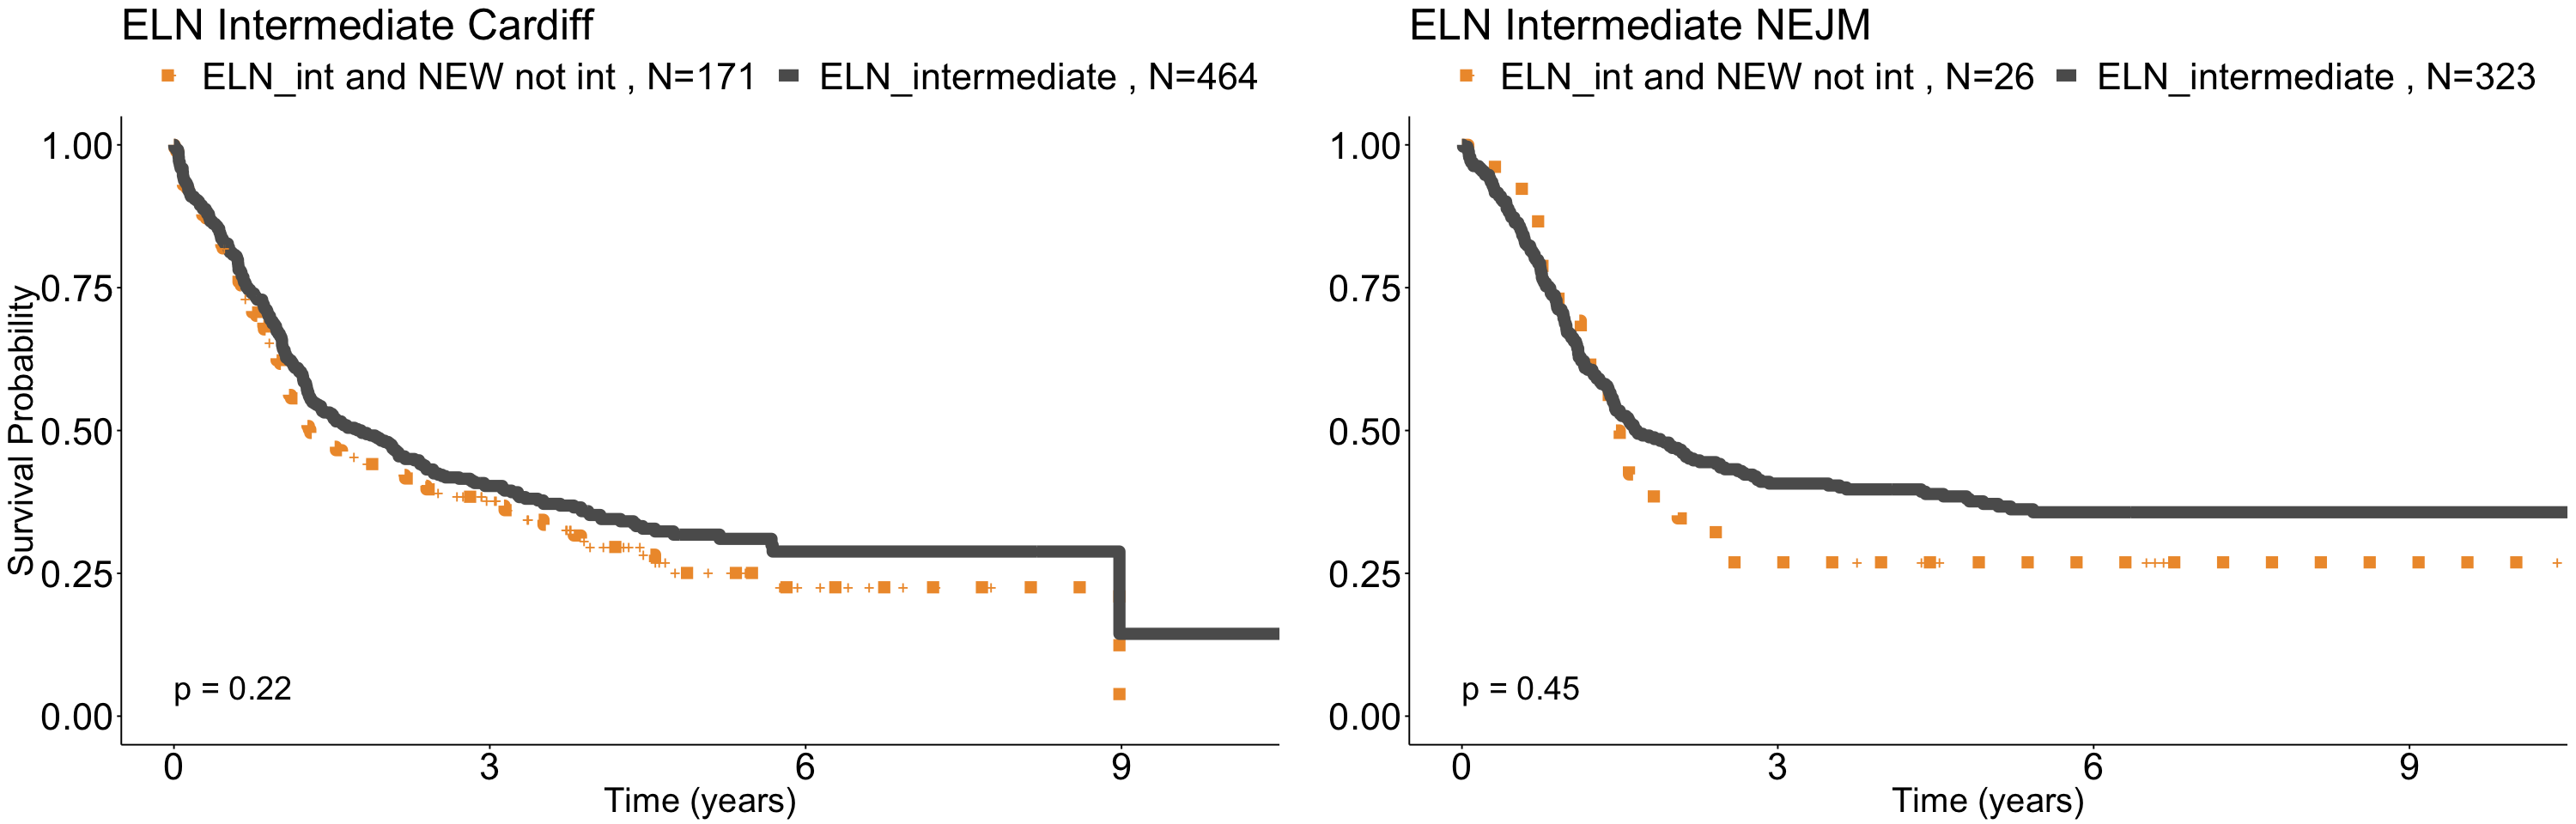

In [76]:
# NEW Intersect

tmp <- df_final[df_final$eln_2017_intermediate!=1 & df_final$molecular_classification=="intermediate",]
tmp$comparison <- "NEW_int and ELN not int"

tmp1 <- df_final[df_final$molecular_classification=="intermediate",]

tmp1$comparison <- paste("NEW",tmp1$molecular_classification,sep="_")
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,linetype=c(3,1),font.legend=26,submain="Proposal Intermediate Cardiff",
                      xlim=c(0,10),break.time.by=3,y="Survival Probability")

tmp <- df_nejm[df_nejm$eln_2017_intermediate!=1 & df_nejm$molecular_classification=="intermediate",]
tmp$comparison <- "NEW_int and ELN not int"

tmp1 <- df_nejm[df_nejm$molecular_classification=="intermediate",]

tmp1$comparison <- paste("NEW",tmp1$molecular_classification,sep="_")
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$OS, event = tmp$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp)
q <- plot_surv_curves(fit,linetype=c(3,1,3,1),font.legend=26,"Proposal Intermediate NEJM",xlim=c(0,10),break.time.by=3)

grid.arrange(p$plot,q$plot,nrow=1)

#ELN Intersect

tmp <- df_final[df_final$eln_2017_intermediate==1 & df_final$molecular_classification!="intermediate",]
tmp$comparison <- "ELN_int and NEW not int"

tmp1 <- df_final[df_final$eln_2017_intermediate==1,]

tmp1$comparison <- ifelse(tmp1$eln_2017_adverse==1,"ELN_adverse",
                          ifelse(tmp1$eln_2017_intermediate==1,"ELN_intermediate","ELN_intermediate"))
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,linetype=c(3,1,3,1),font.legend=26,submain="ELN Intermediate Cardiff",
                      xlim=c(0,10),break.time.by=3,y="Survival Probability")

tmp <- df_nejm[df_nejm$eln_2017_intermediate==1 & df_nejm$molecular_classification!="intermediate",]
tmp$comparison <- "ELN_int and NEW not int"

tmp1 <- df_nejm[df_nejm$eln_2017_intermediate==1,]

tmp1$comparison <- ifelse(tmp1$eln_2017_adverse==1,"ELN_adverse",
                          ifelse(tmp1$eln_2017_intermediate==1,"ELN_intermediate","ELN_intermediate"))
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$OS, event = tmp$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp)
q <- plot_surv_curves(fit,linetype=c(3,1,3,1),font.legend=26,submain="ELN Intermediate NEJM",xlim=c(0,10),break.time.by=3)

grid.arrange(p$plot,q$plot,nrow=1)



# Adverse

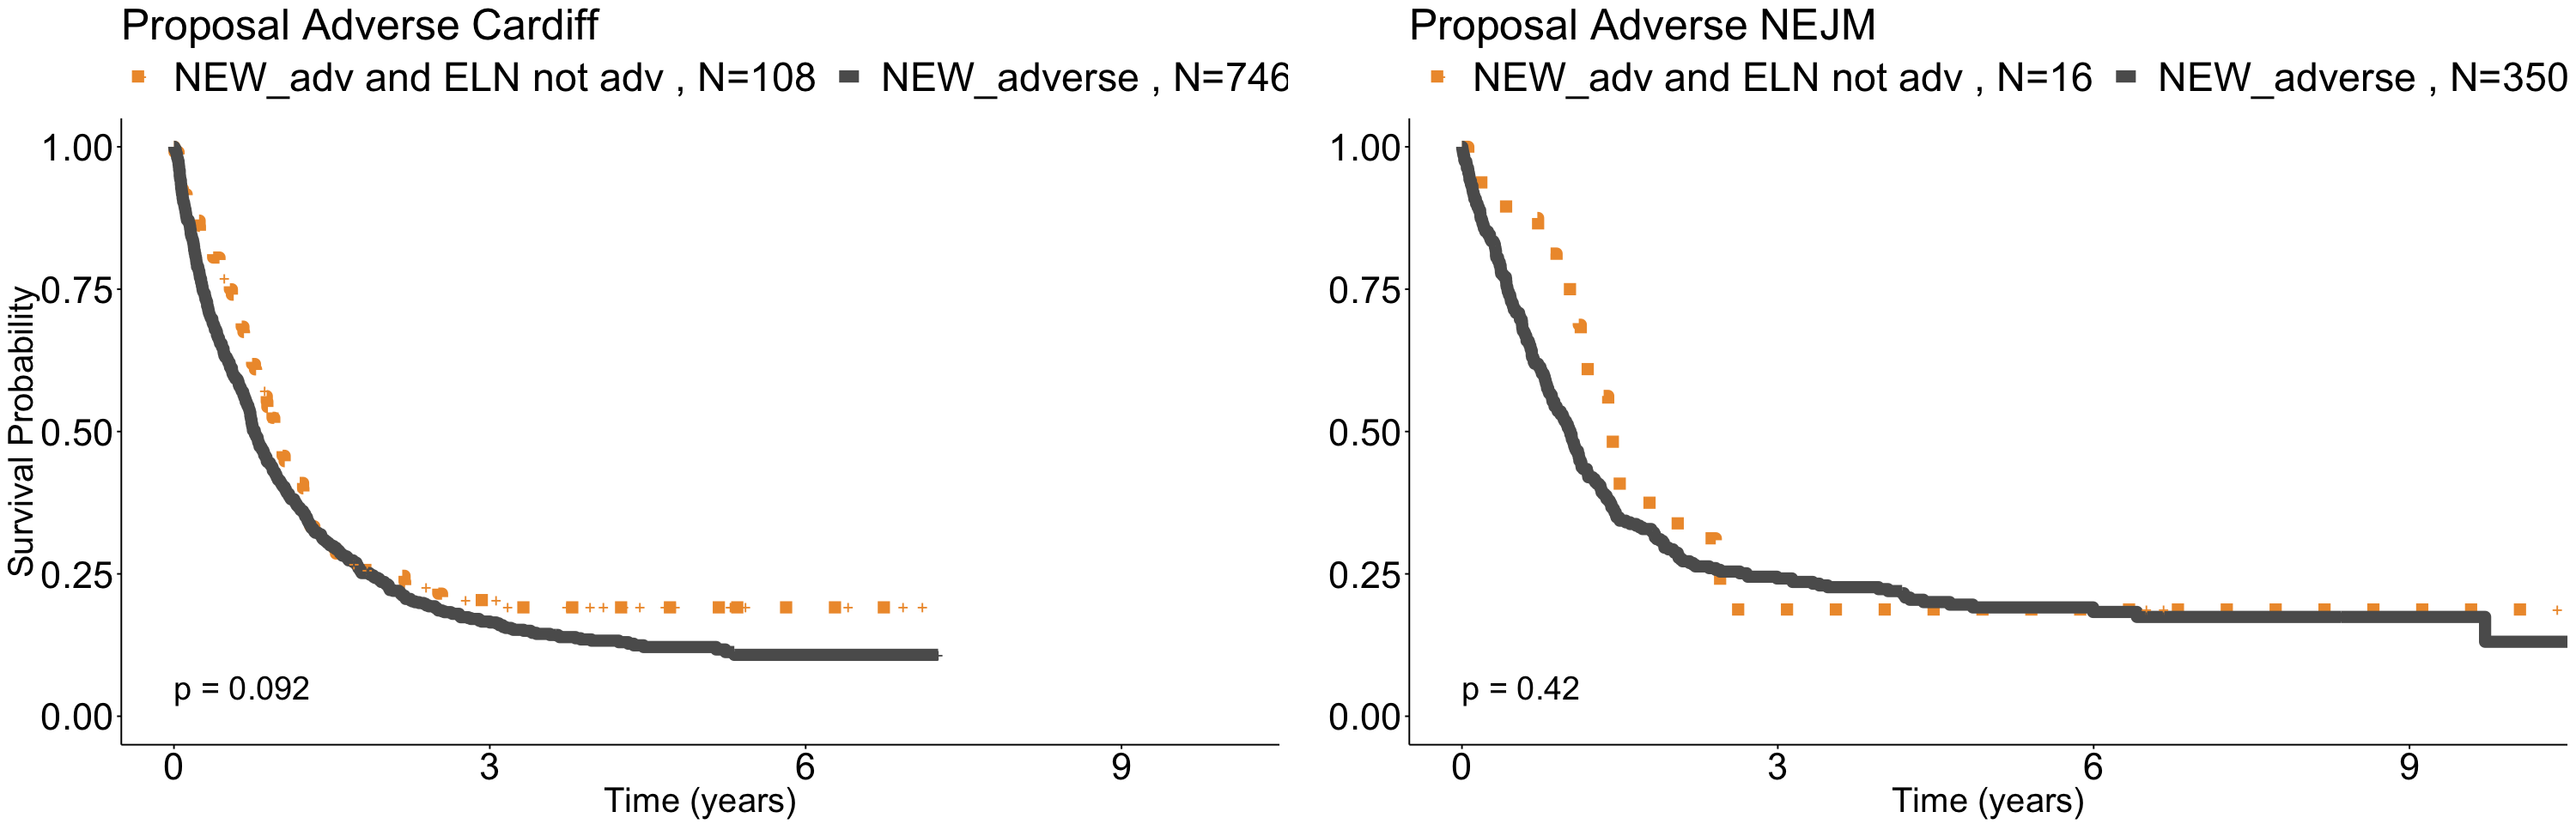

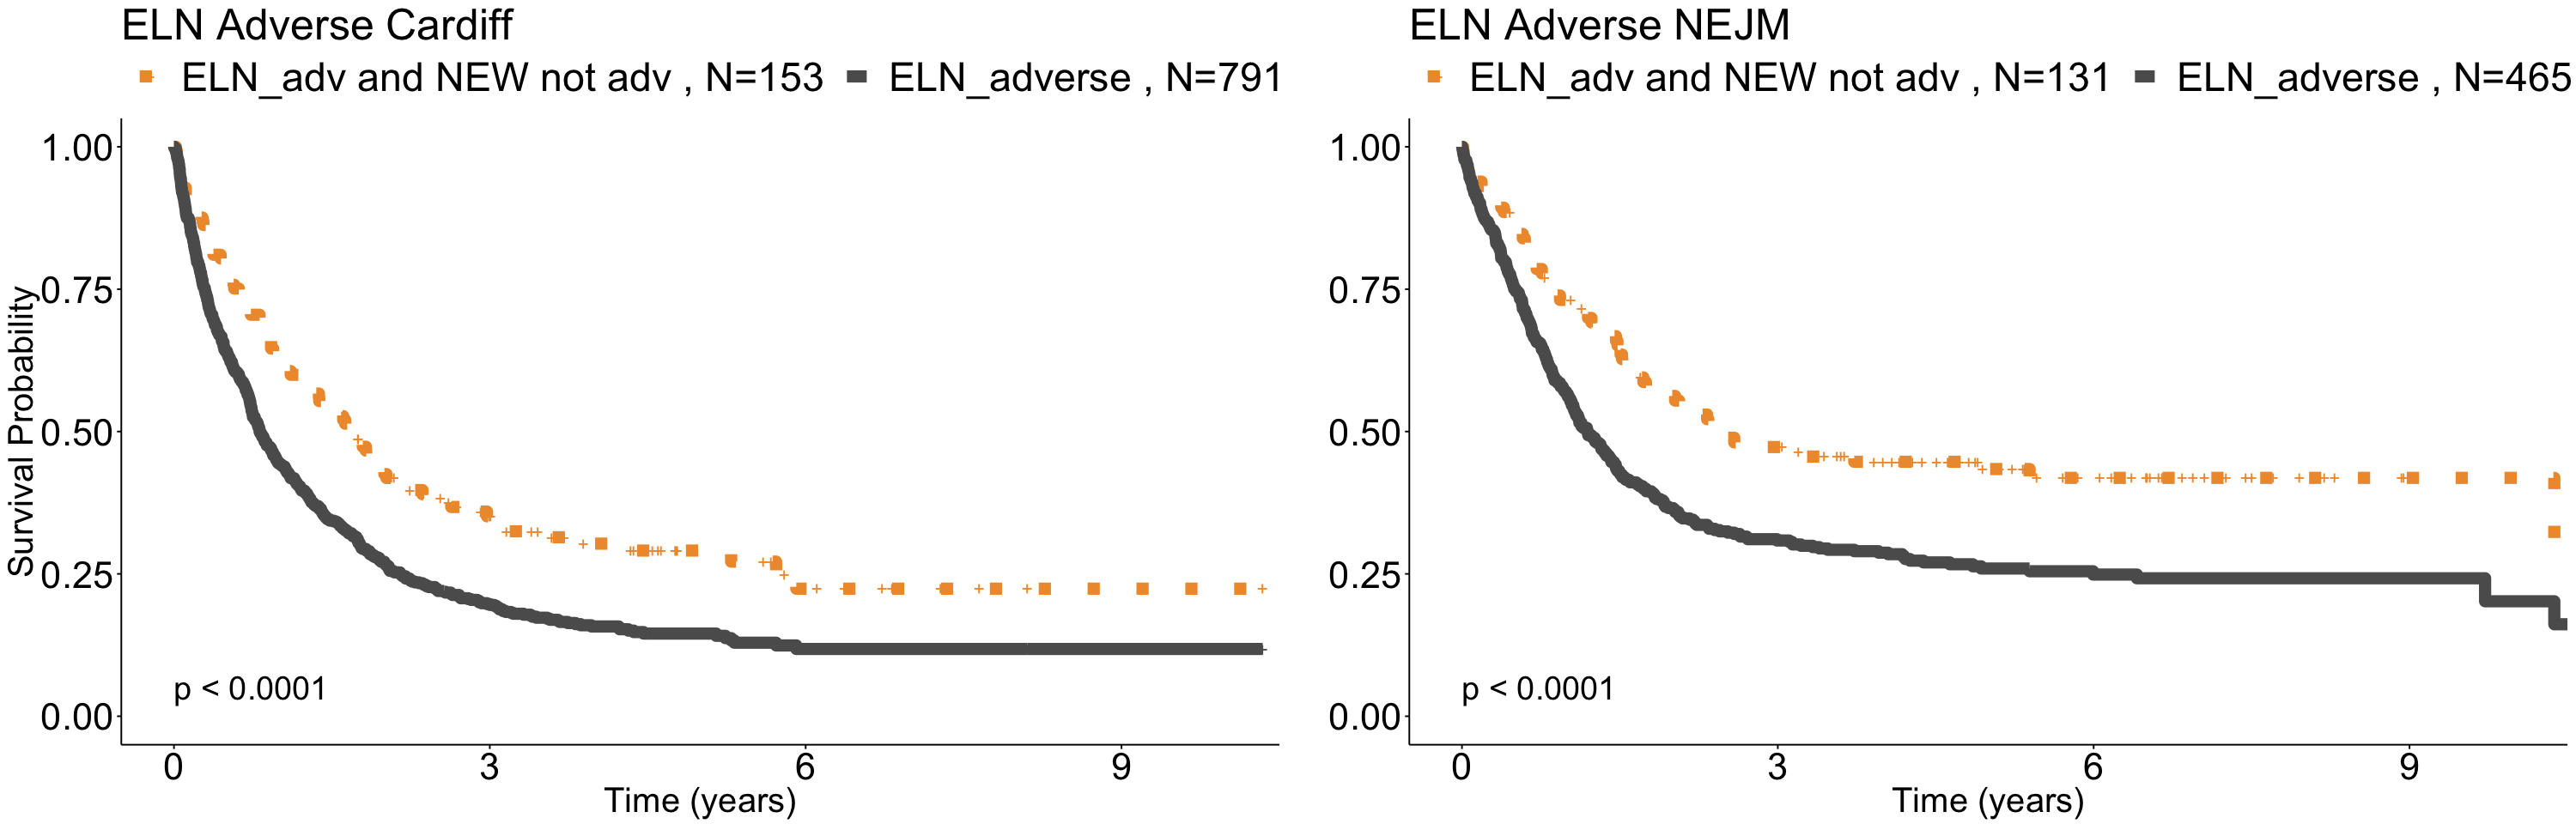

In [77]:
# NEW Intersect

tmp <- df_final[df_final$eln_2017_adverse!=1 & df_final$molecular_classification=="adverse",]
tmp$comparison <- "NEW_adv and ELN not adv"

tmp1 <- df_final[df_final$molecular_classification=="adverse",]

tmp1$comparison <- paste("NEW",tmp1$molecular_classification,sep="_")
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,linetype=c(3,1),submain="Proposal Adverse Cardiff",xlim=c(0,10),break.time.by=3,y="Survival Probability")

tmp <- df_nejm[df_nejm$eln_2017_adverse!=1 & df_nejm$molecular_classification=="adverse",]
tmp$comparison <- "NEW_adv and ELN not adv"

tmp1 <- df_nejm[df_nejm$molecular_classification=="adverse",]

tmp1$comparison <- paste("NEW",tmp1$molecular_classification,sep="_")
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$OS, event = tmp$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp)
q <- plot_surv_curves(fit,linetype=c(3,1,3,1),submain="Proposal Adverse NEJM",xlim=c(0,10),break.time.by=3)

grid.arrange(p$plot,q$plot,nrow=1)

#ELN Intersect

tmp <- df_final[df_final$eln_2017_adverse==1 & df_final$molecular_classification!="adverse",]
tmp$comparison <- "ELN_adv and NEW not adv"

tmp1 <- df_final[df_final$eln_2017_adverse==1,]

tmp1$comparison <- ifelse(tmp1$eln_2017_adverse==1,"ELN_adverse",
                          ifelse(tmp1$eln_2017_intermediate==1,"ELN_intermediate","ELN_adverse"))
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,linetype=c(3,1,3,1),submain="ELN Adverse Cardiff",xlim=c(0,10),break.time.by=3,y="Survival Probability")

tmp <- df_nejm[df_nejm$eln_2017_adverse==1 & df_nejm$molecular_classification!="adverse",]
tmp$comparison <- "ELN_adv and NEW not adv"

tmp1 <- df_nejm[df_nejm$eln_2017_adverse==1,]

tmp1$comparison <- ifelse(tmp1$eln_2017_adverse==1,"ELN_adverse",
                          ifelse(tmp1$eln_2017_intermediate==1,"ELN_intermediate","ELN_adverse"))
                          
tmp <- rbind(tmp,tmp1)

surv_object <- Surv(time = tmp$OS, event = tmp$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp)
q <- plot_surv_curves(fit,linetype=c(3,1,3,1),submain="ELN Adverse NEJM",xlim=c(0,10),break.time.by=3)

grid.arrange(p$plot,q$plot,nrow=1)


# Component introduced in ELN

# Favorable

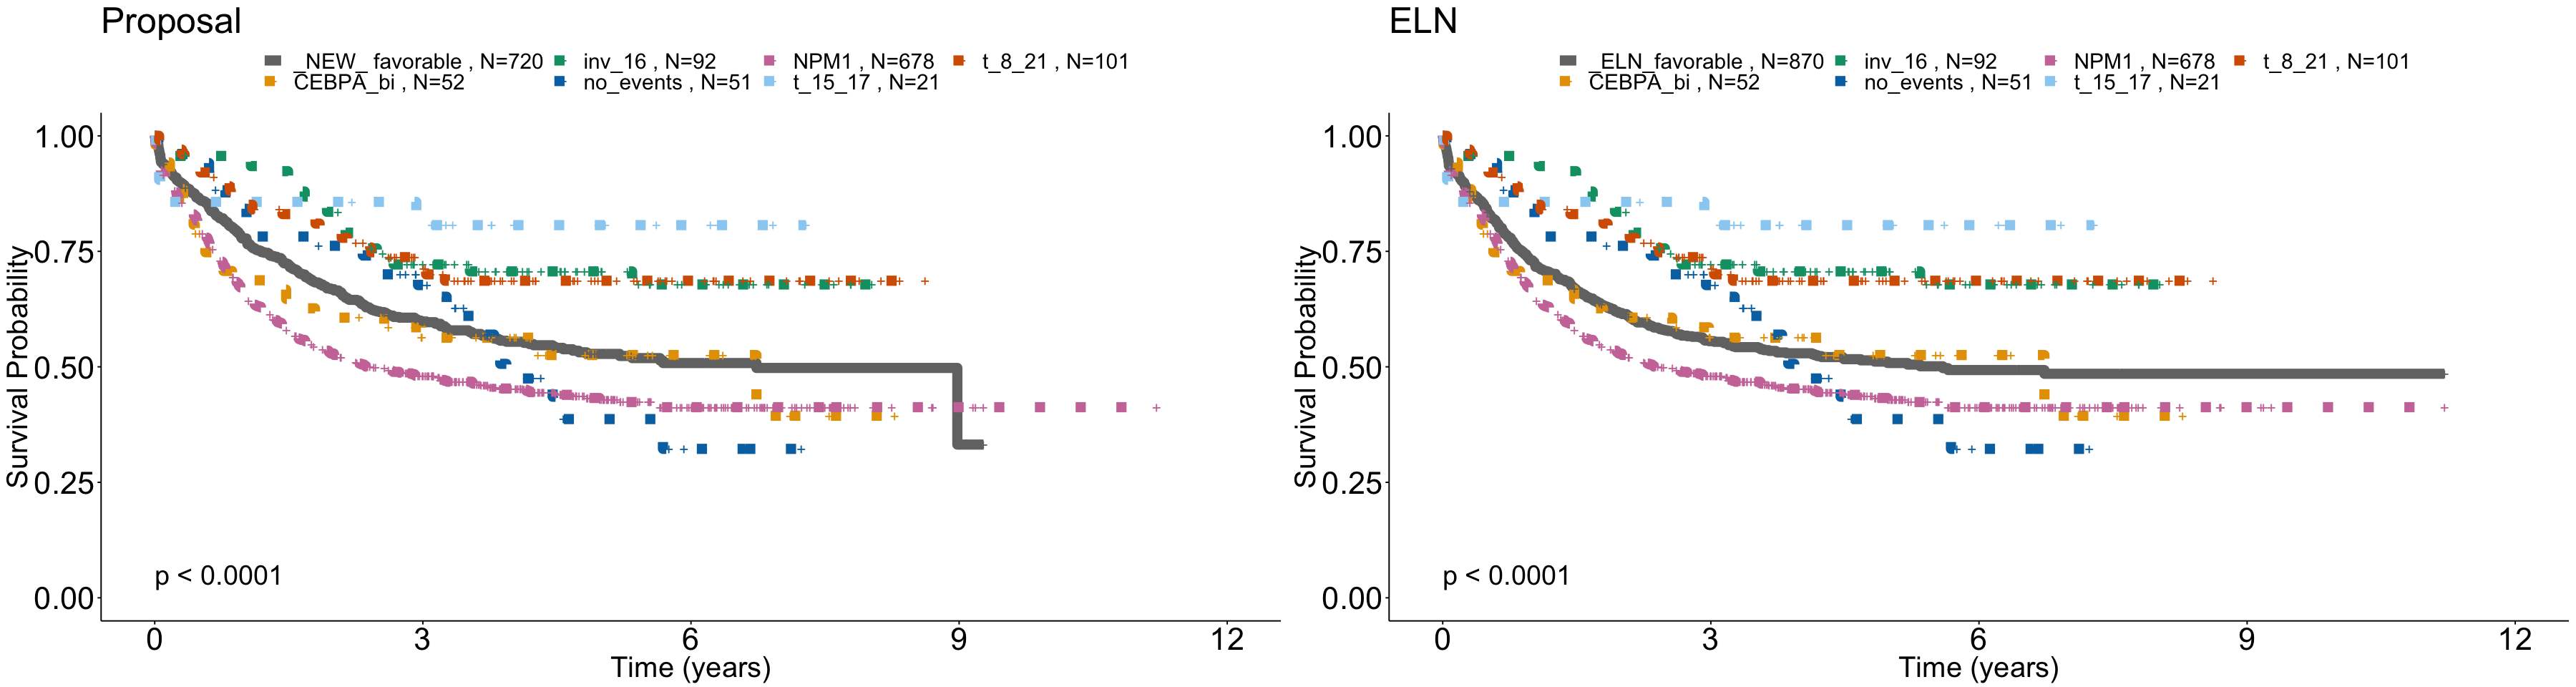

In [122]:
# colors <- as.vector(unlist(color_values))

set_notebook_plot_size(30,8)
for (i in 1:2){
    favorable <- c("full_component_t_15_17","full_component_t_8_21","full_component_inv_16","full_component_CEBPA_bi","full_component_NPM1","full_component_no_events")
    tmp <- NULL
    for (col in favorable){
        tmp1 <- df_final[df_final[,col]==1,]
        tmp1$comparison <- str_remove(col,"full_component_")
        tmp <- rbind(tmp,tmp1)
        }

    if (i==2){
        tmp1 <- df_final[df_final$eln_2017==3,]

        tmp1$comparison <- ifelse(tmp1$eln_2017==1,"_ELN_adverse",
                                  ifelse(tmp1$eln_2017==2,"_ELN_intermediate","_ELN_favorable"))
    }else{
        tmp1 <- df_final[df_final$molecular_classification=="favorable",]
        tmp1$comparison <-  paste("_NEW_",tmp1$molecular_classification)
    }

    tmp <- rbind(tmp,tmp1)

    surv_object <- Surv(time = tmp$os, event = tmp$os_status)
    fit <- survfit(surv_object ~ comparison, data = tmp)
    p[[i]] <- plot_surv_curves(fit,vals=colors,linetype=c(1,rep(3,16)),y="Survival Probability",font.legend=18,submain=ifelse(i==2,"ELN","Proposal"))
}
grid.arrange(p[[1]]$plot,p[[2]]$plot,nrow=1)



# Intermediate

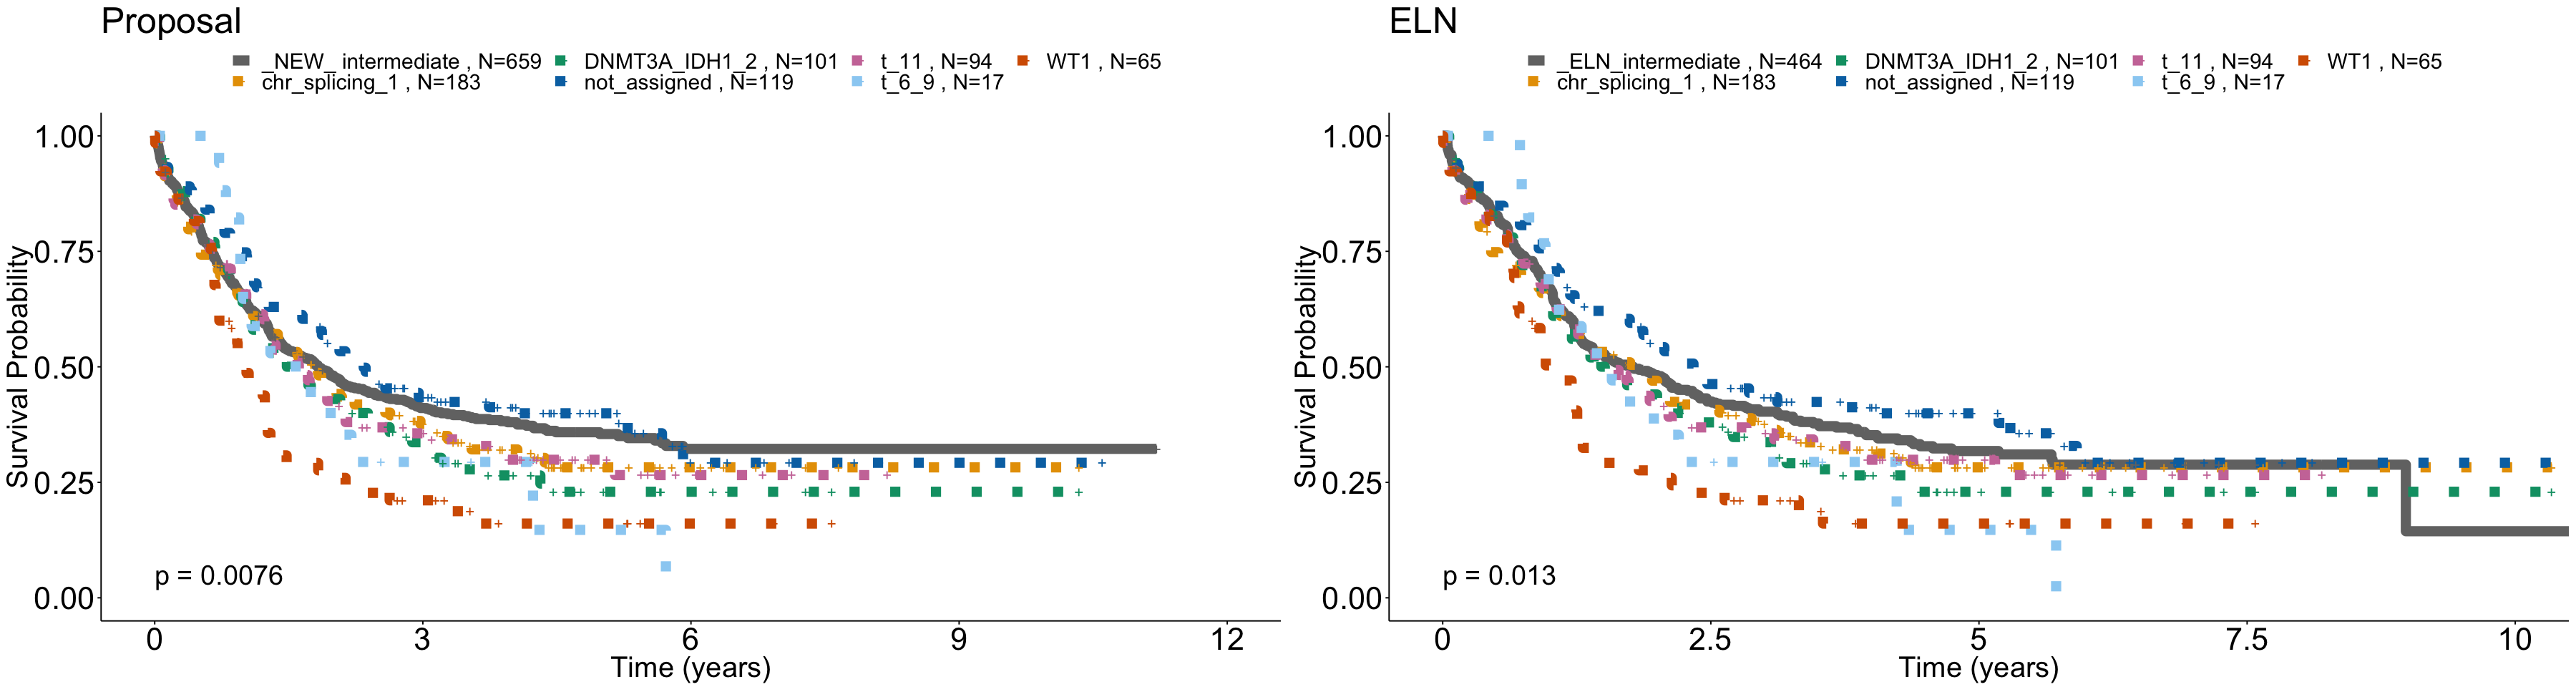

In [121]:
set_notebook_plot_size(30,8)
for (i in 1:2){
    intermediate <- c("full_component_chr_splicing_1","full_component_t_11","full_component_t_6_9","full_component_WT1","full_component_DNMT3A_IDH1_2","full_component_not_assigned")
    tmp <- NULL
    for (col in intermediate){
        tmp1 <- df_final[df_final[,col]==1,]
        tmp1$comparison <- str_remove(col,"full_component_")
        tmp <- rbind(tmp,tmp1)
        }

    if (i==2){
        tmp1 <- df_final[df_final$eln_2017==2,]

        tmp1$comparison <- ifelse(tmp1$eln_2017==1,"_ELN_adverse",
                                  ifelse(tmp1$eln_2017==2,"_ELN_intermediate","_ELN_favorable"))
    }else{
        tmp1 <- df_final[df_final$molecular_classification=="intermediate",]
        tmp1$comparison <-  paste("_NEW_",tmp1$molecular_classification)
    }

    tmp <- rbind(tmp,tmp1)

    surv_object <- Surv(time = tmp$os, event = tmp$os_status)
    fit <- survfit(surv_object ~ comparison, data = tmp)
    p[[i]] <- plot_surv_curves(fit,vals=colors,linetype=c(1,rep(3,16)),y="Survival Probability",font.legend=18,submain=ifelse(i==2,"ELN","Proposal"))
}
grid.arrange(p[[1]]$plot,p[[2]]$plot,nrow=1)


# Adverse

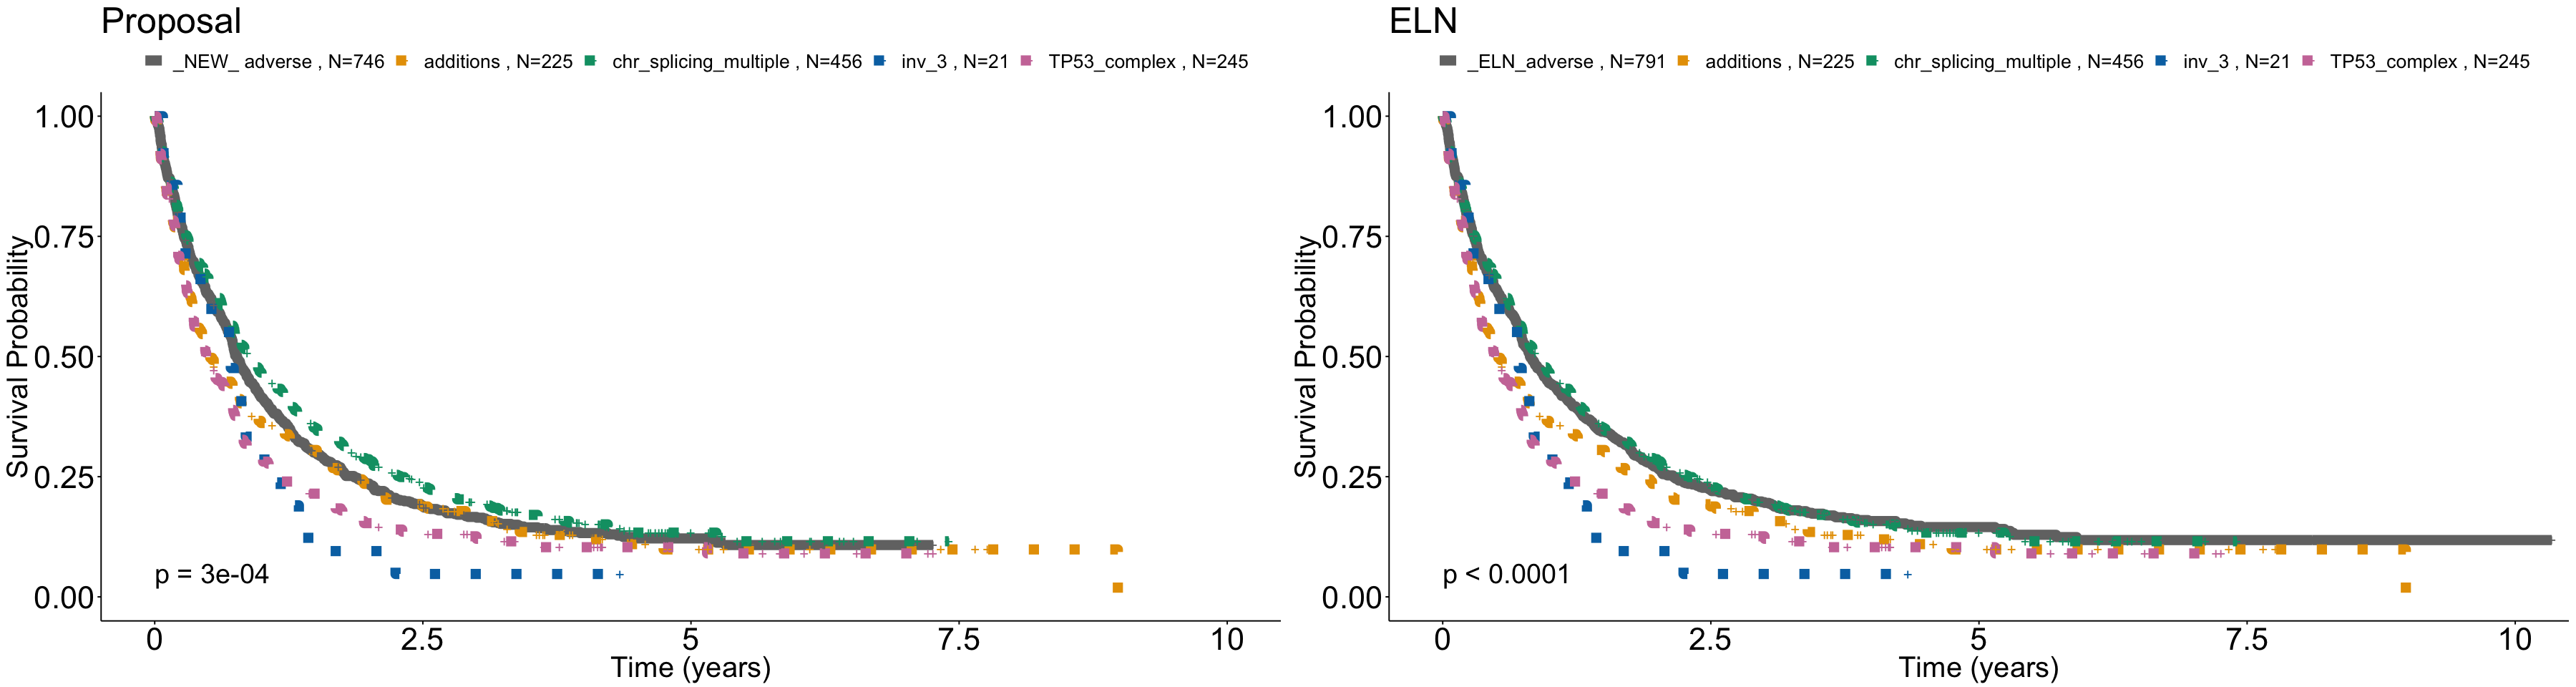

In [120]:
set_notebook_plot_size(30,8)
for (i in 1:2){
    adverse <- c("full_component_chr_splicing_multiple","full_component_additions","full_component_TP53_complex","full_component_inv_3")
    tmp <- NULL
    for (col in adverse){
        tmp1 <- df_final[df_final[,col]==1,]
        tmp1$comparison <- str_remove(col,"full_component_")
        tmp <- rbind(tmp,tmp1)
        }

    if (i==2){
        tmp1 <- df_final[df_final$eln_2017==1,]

        tmp1$comparison <- ifelse(tmp1$eln_2017==1,"_ELN_adverse",
                                  ifelse(tmp1$eln_2017==2,"_ELN_intermediate","_ELN_favorable"))
    }else{
        tmp1 <- df_final[df_final$molecular_classification=="adverse",]
        tmp1$comparison <-  paste("_NEW_",tmp1$molecular_classification)
    }

    tmp <- rbind(tmp,tmp1)

    surv_object <- Surv(time = tmp$os, event = tmp$os_status)
    fit <- survfit(surv_object ~ comparison, data = tmp)
    p[[i]] <- plot_surv_curves(fit,vals=colors,linetype=c(1,rep(3,16)),y="Survival Probability",font.legend=16,submain=ifelse(i==2,"ELN","Proposal"))
}
grid.arrange(p[[1]]$plot,p[[2]]$plot,nrow=1)

In [124]:
library("p3state.msm")

In [125]:
data("heart2")

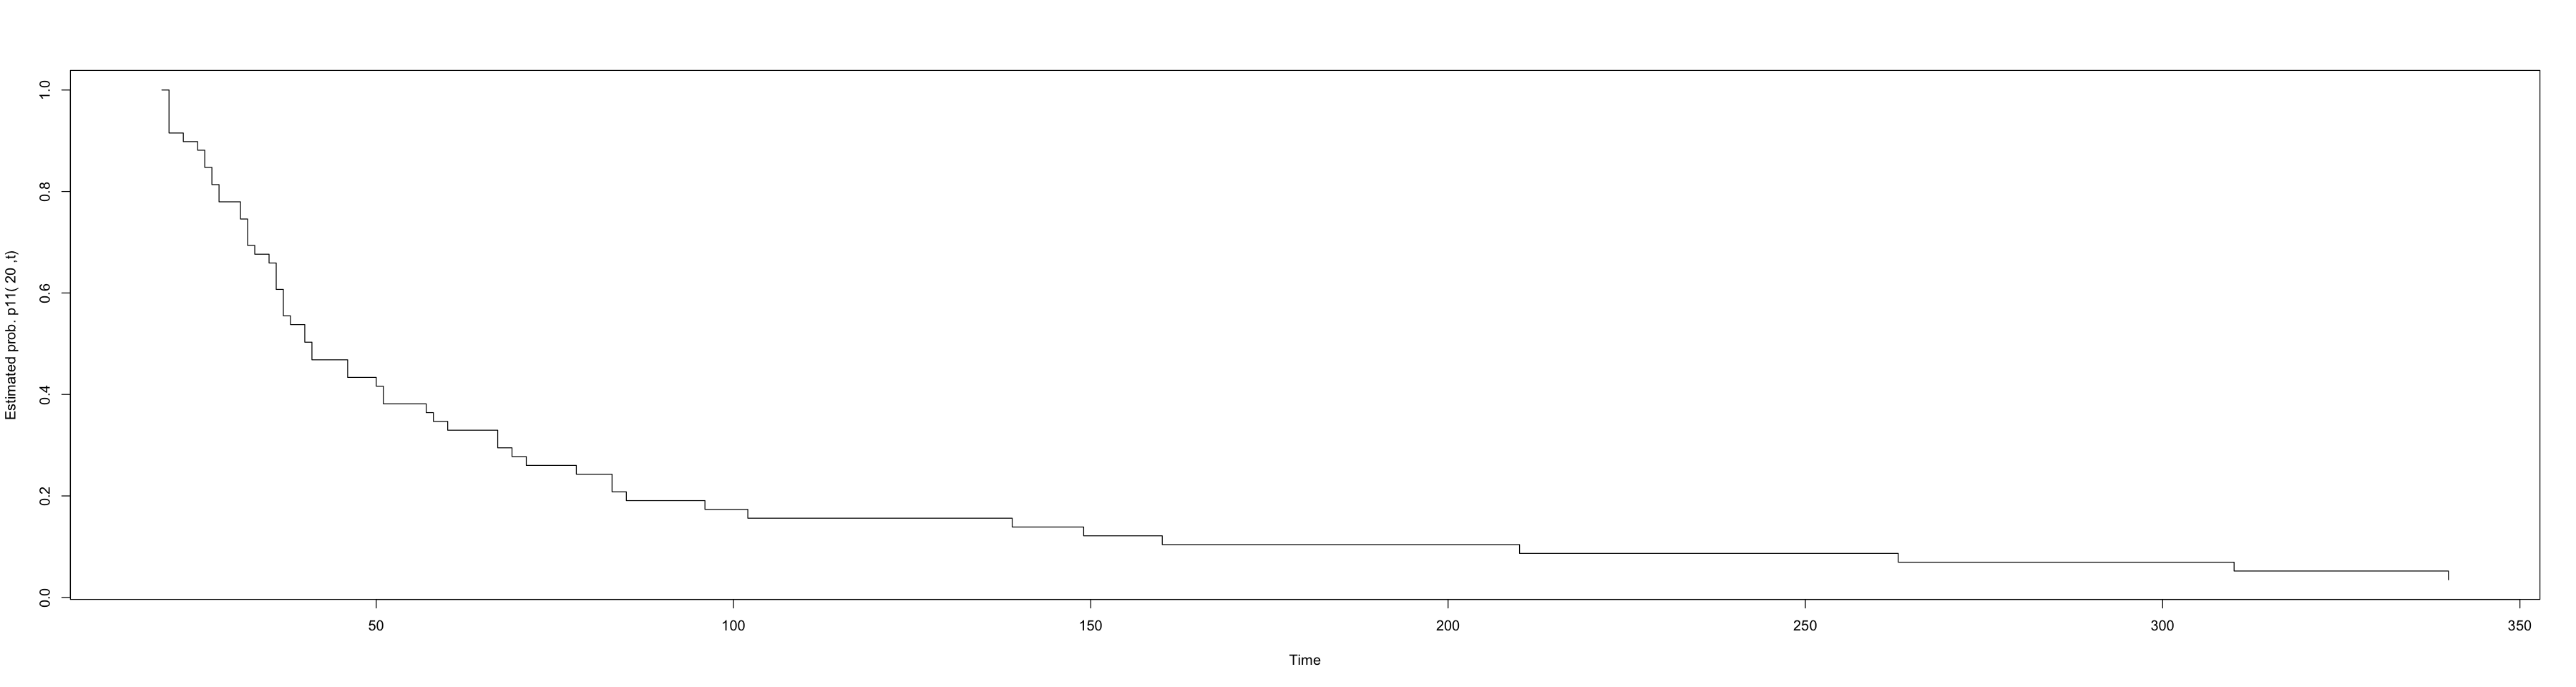

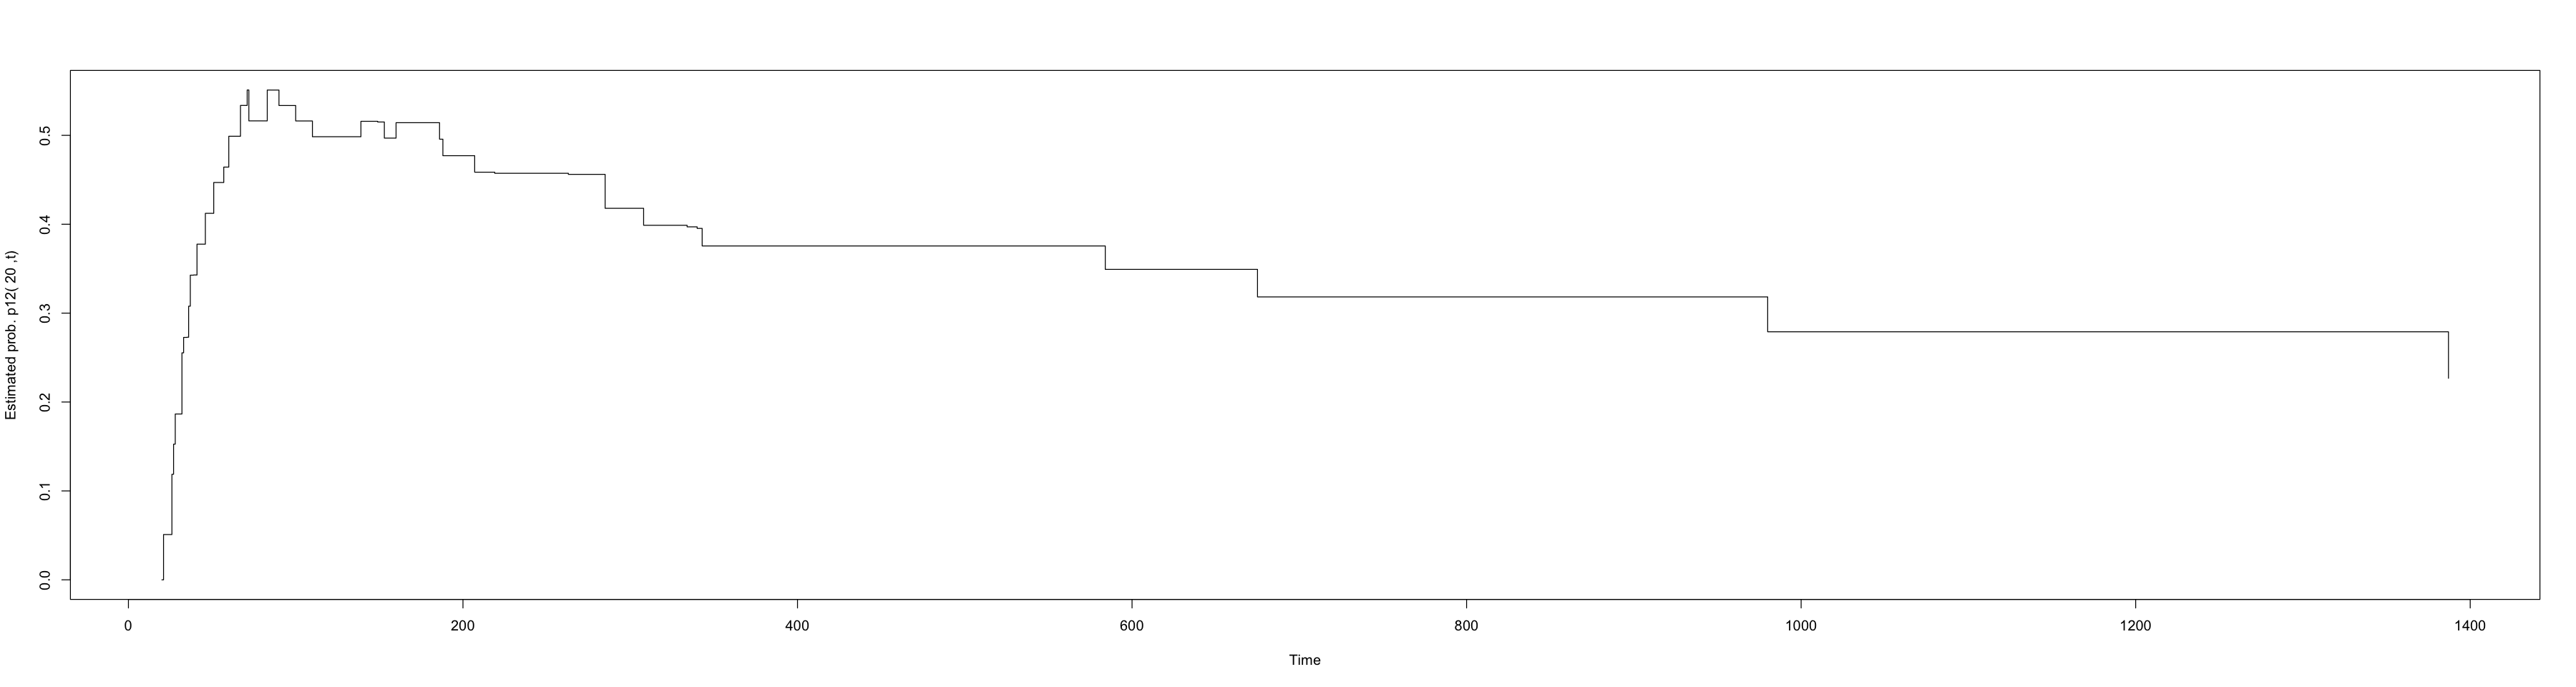

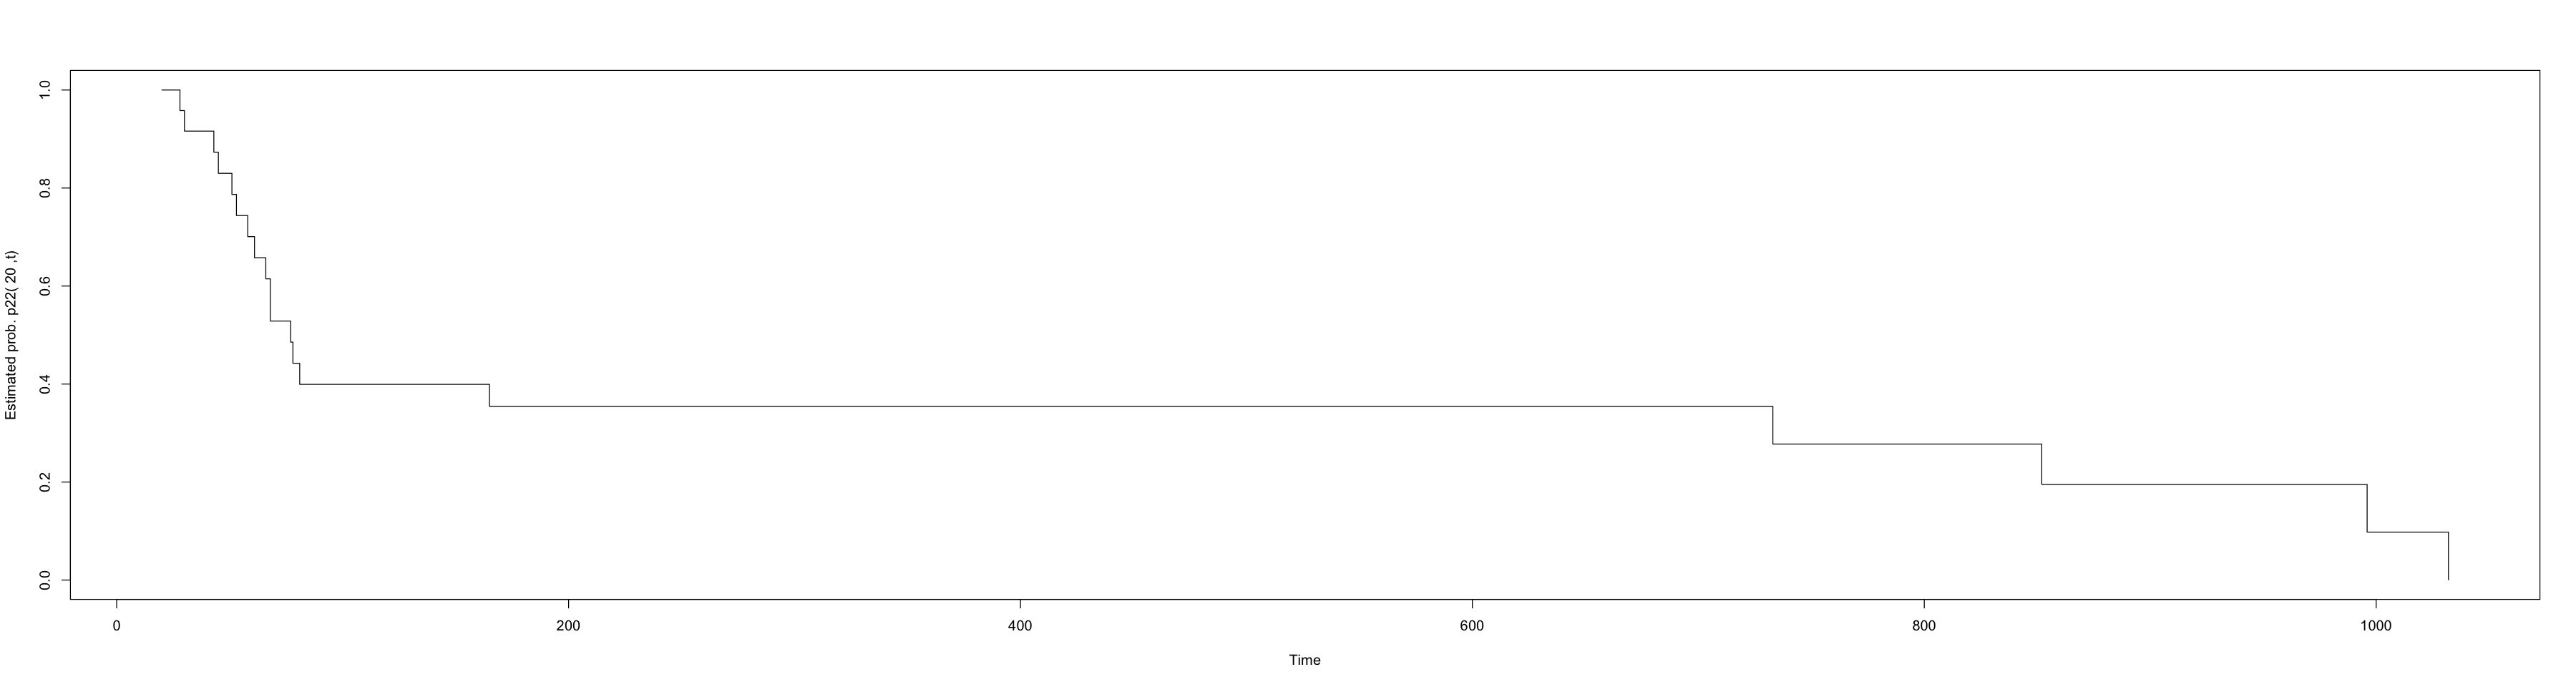

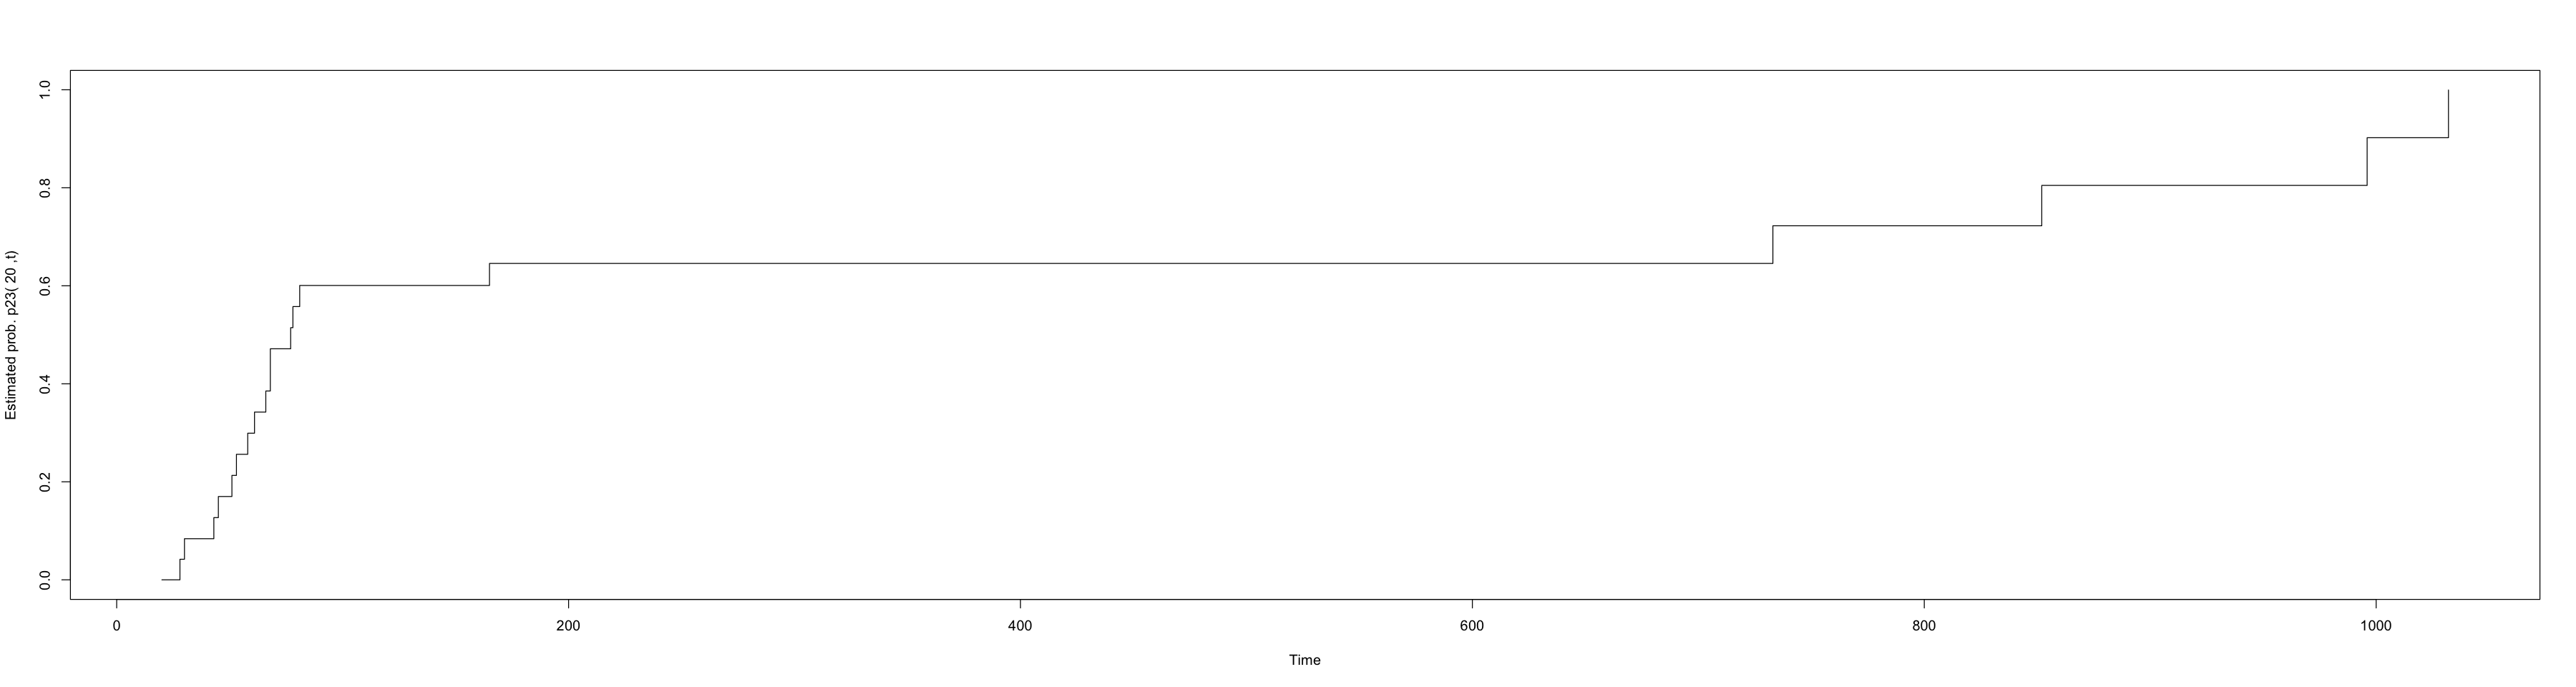

In [137]:
obj1.p3state <- p3state(heart2, formula = ~ age + year + surgery)
plot(obj1.p3state,plot.trans = "all", time1 = 20)

In [132]:
nrow(heart2[heart2$times1>0 & heart2$times2==0,])

[1] 34

In [128]:
colnames(master)

[1] "X"                       "donor_id"               
  [3] "data_pd"                 "sample_pd.x"            
  [5] "ASXL1"                   "ASXL2"                  
  [7] "ASXL3"                   "ATRX"                   
  [9] "BAGE3"                   "BCOR"                   
 [11] "BRAF"                    "CBFB"                   
 [13] "CBL"                     "CDKN2A"                 
 [15] "CEBPA_bi"                "CEBPA_mono"             
 [17] "CNTN5"                   "CREBBP"                 
 [19] "CSF1R"                   "CSF3R"                  
 [21] "CTCF"                    "CUL2"                   
 [23] "CUX1"                    "DNMT3A"                 
 [25] "EED"                     "ETV6"                   
 [27] "EZH2"                    "FBXW7"                  
 [29] "FLT3_ITD"                "FLT3_TKD"               
 [31] "FLT3_other"              "GATA1"                  
 [33] "GATA2"                   "GNAS"                   
 [35] "GNB1"                    "IDH1"                   
 [37] "IDH2_p.R140"             "IDH2_p.R172"            
 [39] "JAK2"                    "JAK3"                   
 [41] "KANSL1"                  "KDM6A"                  
 [43] "KIT"                     "KMT2C"                  
 [45] "KMT2D"                   "KMT2E"                  
 [47] "KRAS"                    "LUC7L2"                 
 [49] "MED12"                   "MLL"                    
 [51] "MPL"                     "MYC"                    
 [53] "NF1"                     "NFE2"                   
 [55] "NOTCH1"                  "NPM1"                   
 [57] "NRAS_other"              "NRAS_p.G12_13"          
 [59] "NRAS_p.Q61_62"           "PDS5B"                  
 [61] "PHF6"                    "PPFIA2"                 
 [63] "PRPF8"                   "PTEN"                   
 [65] "PTPN11"                  "PTPRF"                  
 [67] "PTPRT"                   "RAD21"                  
 [69] "RIT1"                    "RUNX1"                  
 [71] "S100B"                   "SETBP1"                 
 [73] "SF1"                     "SF3B1"                  
 [75] "SMC1A"                   "SMC3"                   
 [77] "SMG1"                    "SPP1"                   
 [79] "SRSF2"                   "STAG2"                  
 [81] "STAT5B"                  "SUZ12"                  
 [83] "TET2"                    "TP53"                   
 [85] "U2AF1"                   "WT1"                    
 [87] "ZRSR2"                   "trial.x"                
 [89] "date_entry"              "gender"                 
 [91] "age"                     "ethnic"                 
 [93] "ahd"                     "perf_status"            
 [95] "secondary"               "wbc"                    
 [97] "hb"                      "plt"                    
 [99] "bm_blasts"               "neut"                   
[101] "intense"                 "trtcode"                
[103] "acmarr"                  "acmcar"                 
[105] "acmhvd"                  "acmibd"                 
[107] "acmdia"                  "acmcvd"                 
[109] "acmpsy"                  "acmobe"                 
[111] "acminf"                  "acmrhe"                 
[113] "acmpep"                  "acmren"                 
[115] "acmpulmod"               "acmpulsev"              
[117] "acmpri"                  "acmhepmil"              
[119] "acmhepsev"               "acmoth"                 
[121] "cod"                     "cr"                     
[123] "os"                      "os_status"              
[125] "pbmts"                   "pbmty"                  
[127] "t_v_11"                  "add_10p"                
[129] "add_10q"                 "add_11p"                
[131] "add_11q"                 "add_12p"                
[133] "add_12q"                 "add_13p"                
[135] "add_13q"                 "add_14p"                
[137] "add_14q"                 "add_15p"                
